## Other Cities: Chicago, Houston, San Diego, Phoenix, Los Angeles, San Diego, Philadelphia, Dallas, San Francisco

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import json
import seaborn as sns

%matplotlib inline

## merge the two raw data once and do not repeat more than once

## Load the merged data for all 10 cities

In [2]:
path = "C:/Users/mchukwu/Desktop/sgpcore_newyork/sgcore_others/extracted_monthly_patterns_10_cities.xlsx"

In [3]:
with open(path,'rb') as f:
    df = pd.read_excel(f)

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df['poi_geoid'] = df['poi_cbg'].apply(lambda x: '{:.0f}'.format(x))

In [6]:
df.shape

(23417, 54)

In [7]:
list(df.columns)

['placekey',
 'parent_placekey',
 'safegraph_brand_ids',
 'location_name',
 'brands',
 'store_id',
 'top_category',
 'sub_category',
 'naics_code',
 'latitude',
 'longitude',
 'street_address',
 'city',
 'region',
 'postal_code',
 'open_hours',
 'category_tags',
 'opened_on',
 'closed_on',
 'tracking_closed_since',
 'websites',
 'geometry_type',
 'polygon_wkt',
 'polygon_class',
 'enclosed',
 'phone_number',
 'is_synthetic',
 'includes_parking_lot',
 'iso_country_code',
 'wkt_area_sq_meters',
 'date_range_start',
 'date_range_end',
 'raw_visit_counts',
 'raw_visitor_counts',
 'visits_by_day',
 'poi_cbg',
 'visitor_home_cbgs',
 'visitor_home_aggregation',
 'visitor_daytime_cbgs',
 'visitor_country_of_origin',
 'distance_from_home',
 'median_dwell',
 'bucketed_dwell_times',
 'related_same_day_brand',
 'related_same_month_brand',
 'popularity_by_hour',
 'popularity_by_day',
 'device_type',
 'normalized_visits_by_state_scaling',
 'normalized_visits_by_region_naics_visits',
 'normalized_vis

In [8]:
list(df['city'].unique())

['Chicago',
 'Dallas',
 'Houston',
 'Los Angeles',
 'Philadelphia',
 'Phoenix',
 'San Diego',
 'San Francisco',
 'San Jose',
 'New York']

## Explode the visitor_home_cbgs json dictionary

In [9]:
def vertically_explode_json(df_, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count'):
    # This function vertically explodes a JSON column in SafeGraph Patterns
    # The resulting dataframe has one row for every data element in all the JSON of all the original rows
    # This is a slow step. If you are working with more than 20,000 rows you should explore faster implementations like pyspark
    #, see here: https://docs.safegraph.com/docs/faqs#section-how-do-i-work-with-the-patterns-columns-that-contain-json

    # Inputs
    #    df -- a pandas.DataFrame -- dataframe with a unique df.index for every row
    #    json_column -- each element of this column is a stringified json blog. No elements can be NULL. # TODO: convert NA JSON columns
    #to empty `{}` so function can handle them and just pass those rows through
    #    key_col_name -- arbitrary string, the name of the column in the output which contains the keys of the key:values of the JSON
    #    value_col_name -- arbitrary string, the name of the column in the output which contains the values of the key:values of the JSON
    # Outputs
    #    df -- a pandas.DataFrame with 2 new columns
    #    1) key_col_name
    #    2) value_col_name

    df = df_.copy()
    if(df.index.unique().shape[0] < df.shape[0]):
        raise("ERROR -- non-unique index found")
    df[json_column+'_dict'] = [json.loads(cbg_json) for cbg_json in df[json_column]]
    all_sgpid_cbg_data = [] # each cbg data point will be one element in this list
    for index, row in df.iterrows():
      # extract each key:value inside each visitor_home_cbg dict (2 nested loops)
      this_sgpid_cbg_data = [ {'orig_index' : index, key_col_name:key, value_col_name:value} for key,value in row[json_column+'_dict'].items() ]
      all_sgpid_cbg_data = all_sgpid_cbg_data + this_sgpid_cbg_data
    output = pd.DataFrame(all_sgpid_cbg_data)
    output.set_index('orig_index', inplace=True)
    return(output)

def explode_visitor_home_cbg(df, json_column='visitor_home_cbgs', key_col_name='visitor_home_cbg', value_col_name='cbg_visitor_count', keep_index=False):
    if(keep_index):
        df['index_original'] = df.index
    df = df.dropna(subset = [json_column]).copy() # Drop nan jsons
    df.reset_index(drop=True, inplace=True) # Every row must have a unique index
    df_exp = vertically_explode_json(df, json_column=json_column, key_col_name=key_col_name, value_col_name=value_col_name)
    df = df.merge(df_exp, left_index=True, right_index=True).reset_index(drop=True)
    return(df)


In [10]:
%%time
sgcoredf = explode_visitor_home_cbg(df)

CPU times: total: 5min 41s
Wall time: 5min 47s


## Select Relevant columns from SafeGraph

In [11]:
sgcore_df = sgcoredf[[#'poi_cbg','wkt_area_sq_meters',
'location_name',
'city',
'date_range_start',
'date_range_end',
'visitor_home_cbg',
'cbg_visitor_count' ,
'raw_visit_counts',
'raw_visitor_counts',              
'median_dwell',
'distance_from_home']]

In [12]:
sgcore_df.sample(10)

,location_name,city,date_range_start,date_range_end,visitor_home_cbg,cbg_visitor_count,raw_visit_counts,raw_visitor_counts,median_dwell,distance_from_home
1072221,New York City Department Of Parks And Recreation,New York,2022-03-01 00:00:00.000,2022-04-01 00:00:00.000,360610309001,4,4822.0,2750.0,3.0,5928.0
725579,Point Loma Tide Pools,San Diego,2022-09-01 00:00:00.000,2022-10-01 00:00:00.000,060730135061,4,1432.0,1284.0,51.0,147922.0
1324480,Upperline Code,New York,2022-06-01 00:00:00.000,2022-07-01 00:00:00.000,360850033002,4,20515.0,12549.0,30.0,18128.0
1197528,Toll Family Playground,New York,2022-04-01 00:00:00.000,2022-05-01 00:00:00.000,360610220005,4,5250.0,3781.0,1.0,9919.0
1264595,My Cooking Party,New York,2022-05-01 00:00:00.000,2022-06-01 00:00:00.000,340230084051,4,6831.0,5274.0,3.0,16552.0
1411109,Caesars Club,New York,2022-07-01 00:00:00.000,2022-08-01 00:00:00.000,360850208012,6,22480.0,18666.0,182.0,41201.0
270015,Bayou Rifles Addicks Range,Houston,2022-04-01 00:00:00.000,2022-05-01 00:00:00.000,480396608023,9,186713.0,52885.0,90.0,16002.0
1413932,Tilyou Playground,New York,2022-07-01 00:00:00.000,2022-08-01 00:00:00.000,360470360021,11,479.0,335.0,51.0,1911.0
454077,Microsoft Theater,Los Angeles,2022-11-01 00:00:00.000,2022-12-01 00:00:00.000,060373023012,10,33904.0,21779.0,40.0,27479.0
1618014,New York City Department Of Parks And Recreation,New York,2022-10-01 00:00:00.000,2022-11-01 00:00:00.000,360850146043,10,1168.0,763.0,1.0,1432.0


In [13]:
sgcore_df.shape

(1804496, 10)

In [14]:
print(sgcore_df['location_name'].nunique())

1542


In [15]:
def compute_visits_by_cbg(df):
    """
    Computes the 'visits_by_cbg' column based on 'cbg_visitor_count', 'raw_visit_counts', 
    and 'raw_visitor_counts'. Then drops the original columns from the DataFrame.
    
    Recommendation:
    Account for associated visits from each home_cbg by SafeGraph.

    Returns:
    pd.DataFrame: DataFrame with the computed 'visits_by_cbg' and without the original columns.
    """
    df.loc[:,'visits_by_cbg'] = df.apply(
        lambda x: round(x['cbg_visitor_count'] * (x['raw_visit_counts'] / x['raw_visitor_counts'])), 
        axis=1
    )
    df.drop(columns=['cbg_visitor_count', 'raw_visit_counts', 'raw_visitor_counts'], inplace=True)
    
    return df

In [16]:
sgcore_df = compute_visits_by_cbg(sgcore_df)

C:\Users\mchukwu\AppData\Local\Temp\ipykernel_53900\4284226406.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'visits_by_cbg'] = df.apply(
C:\Users\mchukwu\AppData\Local\Temp\ipykernel_53900\4284226406.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['cbg_visitor_count', 'raw_visit_counts', 'raw_visitor_counts'], inplace=True)


In [17]:
sgcoredf = sgcore_df[sgcore_df['location_name'].str.contains('Park|park|playground|Playground') == True]

In [18]:
sgcoredf.shape

(503089, 8)

In [19]:
print(sgcoredf['location_name'].nunique())

430


In [20]:
sgcoredf[sgcoredf['city']=='New York'].shape

(345429, 8)

In [21]:
sgcoredf[sgcoredf['city']=='Los Angeles'].shape

(1605, 8)

In [22]:
sgcoredf[sgcoredf['city']=='Chicago'].shape

(4682, 8)

In [23]:
sgcoredf[sgcoredf['city']=='Philadelphia'].shape

(62225, 8)

In [24]:
sgcoredf[sgcoredf['city']=='Houston'].shape

(5050, 8)

In [25]:
sgcoredf[sgcoredf['city']=='Phoenix'].shape

(1886, 8)

In [26]:
sgcoredf[sgcoredf['city']=='San Diego'].shape

(32454, 8)

In [27]:
sgcoredf[sgcoredf['city']=='Dallas'].shape

(2188, 8)

In [28]:
sgcoredf[sgcoredf['city']=='San Jose'].shape

(375, 8)

In [29]:
sgcoredf[sgcoredf['city']=='San Francisco'].shape

(47195, 8)

## TL:DR

In [30]:
sgcoredf_copy = sgcoredf.copy()

In [31]:
visit_per_cbg = (
    sgcoredf_copy.groupby('visitor_home_cbg')[['visits_by_cbg', 'median_dwell', 'distance_from_home']]
    .sum()
    .reset_index()  # Keeps visitor_home_cbg as a regular column
)

visit_per_cbg = pd.DataFrame(visit_per_cbg)

In [32]:
visit_per_cbg

,visitor_home_cbg,visits_by_cbg,median_dwell,distance_from_home
0,010030107011,5,60.0,14702.0
1,010030107053,7,62.0,15162.0
2,010030114051,5,119.0,16365.0
3,010030114062,17,114.0,35824.0
4,010090506011,4,1.0,12161.0
...,...,...,...,...
35348,CA:59153995,5,1.0,15894.0
35349,CA:59154016,7,414.0,7530.0
35350,CA:59154027,6,1.0,14501.0
35351,CA:59154185,6,1.0,12366.0


In [33]:
visit_per_cbg['visitor_home_cbg'].dtype

dtype('O')

In [34]:
filtered_df = visit_per_cbg[visit_per_cbg['visitor_home_cbg'].astype(str).str.contains(r'[A-Za-z]', regex=True)]

In [35]:
filtered_df

,visitor_home_cbg,visits_by_cbg,median_dwell,distance_from_home
35210,CA:24230622,8,52.0,1138.0
35211,CA:24230924,7,93.0,15789.0
35212,CA:24280037,9,159.0,8370.0
35213,CA:24460073,5,1.0,30342.0
35214,CA:24580615,5,20.0,13445.0
...,...,...,...,...
35348,CA:59153995,5,1.0,15894.0
35349,CA:59154016,7,414.0,7530.0
35350,CA:59154027,6,1.0,14501.0
35351,CA:59154185,6,1.0,12366.0


In [36]:
# Remove rows where 'visitor_home_cbg' contains "CA" --> Belongs to Canada
visit_per_cbg = visit_per_cbg[~visit_per_cbg['visitor_home_cbg'].astype(str).str.contains("CA", na=False)]

In [37]:
visit_per_cbg

,visitor_home_cbg,visits_by_cbg,median_dwell,distance_from_home
0,010030107011,5,60.0,14702.0
1,010030107053,7,62.0,15162.0
2,010030114051,5,119.0,16365.0
3,010030114062,17,114.0,35824.0
4,010090506011,4,1.0,12161.0
...,...,...,...,...
35205,721270044001,8,37.0,7170.0
35206,721270063006,6,32.0,6515.0
35207,721270068001,6,32.0,11892.0
35208,721270105001,5,14.0,14657.0


In [38]:
visit_per_cbg.isnull().sum()

visitor_home_cbg      0
visits_by_cbg         0
median_dwell          0
distance_from_home    0
dtype: int64

## Introduce census data

In [39]:
# load census data of all cities

# Load the Excel file
file_path = "./census_data_10_cities.xlsx"  # Change this to your actual file path
census = pd.read_excel(file_path, dtype={'fips_all': str})  # Ensure fips_all is a string

# Ensure all FIPS codes are 12 digits by adding a leading zero where needed
census['fips_all'] = census['fips_all'].apply(lambda x: x.zfill(12) if len(x) == 11 else x)

In [40]:
# Convert visitor_home_cbg column to string type before merging
visit_per_cbg.loc[:, 'visitor_home_cbg'] = visit_per_cbg['visitor_home_cbg'].astype(str)
census.loc[:,'fips_all'] = census['fips_all'].astype(str)

In [41]:
## Merge the visit_per_cbg with census data

mergedf = visit_per_cbg.merge(census,left_on='visitor_home_cbg',right_on='fips_all').drop('fips_all',axis=1)

In [42]:
mergedf['state'].unique()

array(['arizona', 'california', 'illinois', 'new york', 'pennsylvania',
       'texas'], dtype=object)

In [43]:
mergedf

,visitor_home_cbg,visits_by_cbg,median_dwell,distance_from_home,state,total_sex,male,female,15_17y,18_24y,...,high_sch,total_unemp,employed,unemployed,median_income,car,public_trans,walk,15mins,45mins
0,040019705022,7,104.0,12800.0,arizona,1187,736,451,15,9,...,905,393,393,0,99730.0,380,0,0,154,0
1,040030016011,7,91.0,10519.0,arizona,1274,677,597,60,72,...,911,484,463,21,61136.0,466,0,0,252,34
2,040030017012,7,59.0,14203.0,arizona,1120,381,739,22,24,...,827,470,470,0,77734.0,488,0,0,237,0
3,040030017021,5,61.0,11581.0,arizona,1136,485,651,70,46,...,702,361,349,12,NaN,266,0,24,207,0
4,040030019004,7,70.0,9021.0,arizona,1860,919,941,84,110,...,1224,717,639,78,105417.0,525,0,0,160,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21075,484910212021,5,14.0,42476.0,texas,3207,1533,1674,246,304,...,1860,1623,1494,129,85570.0,1296,0,10,272,237
21076,484910215061,7,61.0,17492.0,texas,1957,946,1011,38,144,...,1054,1109,1047,62,113214.0,772,14,11,140,77
21077,484930001042,7,63.0,15179.0,texas,1793,930,863,105,202,...,1187,1009,984,25,93438.0,755,0,0,50,319
21078,484971501011,5,20.0,15926.0,texas,1483,819,664,26,51,...,1028,820,797,23,110917.0,729,0,0,73,169


In [44]:
### Let's do some exploratory data analysis

mergedf.describe()

,visits_by_cbg,median_dwell,distance_from_home,total_sex,male,female,15_17y,18_24y,25_34y,35_44y,...,high_sch,total_unemp,employed,unemployed,median_income,car,public_trans,walk,15mins,45mins
count,21080.000000,21080.000000,2.108000e+04,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000,...,21080.000000,21080.000000,21080.000000,21080.000000,19374.000000,21080.000000,21080.000000,21080.000000,21080.000000,21080.000000
mean,283.688520,859.100712,2.500079e+05,1482.059583,729.559725,752.499858,55.316461,142.570920,220.442410,197.671964,...,895.104791,775.689943,727.565892,48.124051,107755.172551,445.613472,120.665180,31.400474,136.460484,101.120256
std,1019.513395,1708.232936,4.232587e+05,758.271321,414.971130,379.656157,55.741929,278.266941,184.783497,137.789187,...,446.485208,394.862126,376.270859,53.970677,56087.481448,347.362368,169.031888,100.502030,136.501968,88.229887
min,4.000000,1.000000,5.610000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2499.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,31.000000,2.328100e+04,982.000000,472.000000,492.000000,14.000000,48.000000,100.000000,103.000000,...,587.000000,500.000000,465.000000,12.000000,65946.250000,191.000000,5.000000,0.000000,50.000000,39.000000
50%,34.000000,131.000000,7.681600e+04,1371.000000,670.000000,693.000000,41.000000,99.000000,180.000000,172.000000,...,826.000000,714.000000,668.000000,33.000000,96304.500000,388.000000,50.000000,5.000000,108.000000,81.000000
75%,217.000000,919.000000,2.836528e+05,1863.000000,922.250000,952.000000,80.000000,174.000000,293.000000,263.000000,...,1138.000000,989.000000,932.000000,67.000000,138925.000000,634.000000,174.000000,33.000000,191.000000,140.000000
max,40422.000000,28238.000000,6.714466e+06,38907.000000,27065.000000,11842.000000,681.000000,20089.000000,7232.000000,2604.000000,...,10286.000000,7555.000000,7245.000000,978.000000,250001.000000,14622.000000,4336.000000,9426.000000,9436.000000,1900.000000


In [45]:
mergedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21080 entries, 0 to 21079
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   visitor_home_cbg    21080 non-null  object 
 1   visits_by_cbg       21080 non-null  int64  
 2   median_dwell        21080 non-null  float64
 3   distance_from_home  21080 non-null  float64
 4   state               21080 non-null  object 
 5   total_sex           21080 non-null  int64  
 6   male                21080 non-null  int64  
 7   female              21080 non-null  int64  
 8   15_17y              21080 non-null  int64  
 9   18_24y              21080 non-null  int64  
 10  25_34y              21080 non-null  int64  
 11  35_44y              21080 non-null  int64  
 12  45_54y              21080 non-null  int64  
 13  55_64y              21080 non-null  int64  
 14  65_74y              21080 non-null  int64  
 15  75_84y              21080 non-null  int64  
 16  85y+

In [46]:
mergedf_copy = mergedf.copy()

In [47]:
mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith(("36085","36047","36081","36061","36005","06037","48201","06073","48113","06085","06077","42101","04013","17031"))]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("06037")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("48201")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("06073")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("48113")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("06085")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("06077")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("48201")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("04013")]
#mergedf_copy = mergedf_copy[mergedf_copy['visitor_home_cbg'].astype(str).str.startswith("17031")]

In [48]:
mergedf_copy['young'] = mergedf_copy[['15_17y', '18_24y', '25_34y']].sum(axis=1)
mergedf_copy['adult'] = mergedf_copy[['35_44y', '35_44y', '55_64y']].sum(axis=1)
mergedf_copy['elderly'] = mergedf_copy[['65_74y', '75_84y', '85y+']].sum(axis=1)

In [49]:
mergedf_copy['total_pop'] = mergedf_copy[['white','black','asian','hispanic']].sum(axis=1)
mergedf_copy['total_age'] = mergedf_copy[['elderly','young','adult']].sum(axis=1)
mergedf_copy['total_commute'] = mergedf_copy[['15mins','45mins']].sum(axis=1)
mergedf_copy['total_transport'] = mergedf_copy[['car','public_trans','walk']].sum(axis=1)
mergedf_copy['total_edu'] = mergedf_copy[['low_high','high_sch']].sum(axis=1)

In [50]:
# calculate percent for race, education, transportation,traveltime

mergedf_copy['pct_male'] = (mergedf_copy['male'] / mergedf_copy['total_sex']*100).round(2)
mergedf_copy['pct_female'] = (mergedf_copy['female'] / mergedf_copy['total_sex']*100).round(2)
mergedf_copy['pct_white'] = (mergedf_copy['white'] / mergedf_copy['total_pop']*100).round(2)
mergedf_copy['pct_black'] = (mergedf_copy['black'] / mergedf_copy['total_pop']*100).round(2)
mergedf_copy['pct_asian'] = (mergedf_copy['asian'] / mergedf_copy['total_pop']*100).round(2)
mergedf_copy['pct_hispanic'] = (mergedf_copy['hispanic'] / mergedf_copy['total_pop']*100).round(2)
mergedf_copy['pct_young'] = (mergedf_copy['young'] / mergedf_copy['total_age']*100).round(2)
mergedf_copy['pct_adult'] = (mergedf_copy['adult'] / mergedf_copy['total_age']*100).round(2)
mergedf_copy['pct_elderly'] = (mergedf_copy['elderly'] / mergedf_copy['total_age']*100).round(2)
mergedf_copy['pct_low_edu'] = (mergedf_copy['low_high'] / mergedf_copy['total_edu']*100).round(2)
mergedf_copy['pct_high_edu'] = (mergedf_copy['high_sch'] / mergedf_copy['total_edu']*100).round(2)
mergedf_copy['pct_short_comute'] = (mergedf_copy['15mins'] / mergedf_copy['total_commute']*100).round(2)
mergedf_copy['pct_long_comute'] = (mergedf_copy['45mins'] / mergedf_copy['total_commute']*100).round(2)
mergedf_copy['pct_unemp'] = (mergedf_copy['unemployed'] / mergedf_copy['total_unemp']*100).round(2)
mergedf_copy['pct_emp'] = (mergedf_copy['employed'] / mergedf_copy['total_unemp']*100).round(2)
mergedf_copy['pct_car'] = (mergedf_copy['car'] / mergedf_copy['total_transport']*100).round(2)
mergedf_copy['pct_public_trans'] = (mergedf_copy['public_trans'] / mergedf_copy['total_transport']*100).round(2)
mergedf_copy['pct_0car'] = (mergedf_copy['walk'] / mergedf_copy['total_transport']*100).round(2)

In [51]:
mergedf_copy

,visitor_home_cbg,visits_by_cbg,median_dwell,distance_from_home,state,total_sex,male,female,15_17y,18_24y,...,pct_elderly,pct_low_edu,pct_high_edu,pct_short_comute,pct_long_comute,pct_unemp,pct_emp,pct_car,pct_public_trans,pct_0car
16,040130304021,6,97.0,12863.0,arizona,746,414,332,0,0,...,28.31,0.00,100.00,83.04,16.96,3.46,96.54,100.00,0.00,0.00
17,040130405024,8,140.0,8396.0,arizona,888,422,466,0,56,...,27.73,6.27,93.73,100.00,0.00,2.69,97.31,89.69,0.00,10.31
18,040130608022,5,81.0,11827.0,arizona,2032,965,1067,95,224,...,5.50,23.75,76.25,61.93,38.07,7.63,92.37,99.17,0.83,0.00
19,040130610112,5,31.0,18076.0,arizona,1461,651,810,71,73,...,6.18,15.39,84.61,53.43,46.57,7.42,92.58,100.00,0.00,0.00
20,040130610131,13,111.0,29995.0,arizona,2450,1154,1296,28,149,...,10.20,6.39,93.61,62.75,37.25,6.15,93.85,100.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20888,482015560001,67,844.0,120412.0,texas,912,519,393,52,153,...,12.10,10.06,89.94,37.32,62.68,3.81,96.19,100.00,0.00,0.00
20889,482015560002,76,838.0,120179.0,texas,2189,990,1199,0,131,...,12.10,8.96,91.04,100.00,0.00,6.28,93.72,100.00,0.00,0.00
20890,482015560003,65,848.0,120179.0,texas,3280,1597,1683,52,298,...,2.79,12.29,87.71,70.52,29.48,13.22,86.78,92.88,0.00,7.12
20891,482019800001,15,361.0,48786.0,texas,13,7,6,0,0,...,46.15,0.00,100.00,100.00,0.00,0.00,100.00,0.00,53.85,46.15


In [52]:
mergedf_copy.columns

Index(['visitor_home_cbg', 'visits_by_cbg', 'median_dwell',
       'distance_from_home', 'state', 'total_sex', 'male', 'female', '15_17y',
       '18_24y', '25_34y', '35_44y', '45_54y', '55_64y', '65_74y', '75_84y',
       '85y+', 'white', 'black', 'asian', 'hispanic', 'low_high', 'high_sch',
       'total_unemp', 'employed', 'unemployed', 'median_income', 'car',
       'public_trans', 'walk', '15mins', '45mins', 'young', 'adult', 'elderly',
       'total_pop', 'total_age', 'total_commute', 'total_transport',
       'total_edu', 'pct_male', 'pct_female', 'pct_white', 'pct_black',
       'pct_asian', 'pct_hispanic', 'pct_young', 'pct_adult', 'pct_elderly',
       'pct_low_edu', 'pct_high_edu', 'pct_short_comute', 'pct_long_comute',
       'pct_unemp', 'pct_emp', 'pct_car', 'pct_public_trans', 'pct_0car'],
      dtype='object')

In [53]:
columns_to_bring =['visitor_home_cbg', 'state','visits_by_cbg', 'median_dwell','distance_from_home', 'median_income',
                 'pct_male', 'pct_female', 'pct_white', 'pct_black',
                 'pct_asian', 'pct_hispanic','pct_young', 'pct_adult', 'pct_elderly', 'pct_low_edu',
                 'pct_high_edu', 'pct_short_comute', 'pct_long_comute', 'pct_unemp',
                 'pct_emp', 'pct_car', 'pct_public_trans', 'pct_0car']

In [54]:
## New Dataframe and drop missing value rows 

ddf = mergedf_copy[columns_to_bring].dropna()

In [55]:
ddf

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_elderly,pct_low_edu,pct_high_edu,pct_short_comute,pct_long_comute,pct_unemp,pct_emp,pct_car,pct_public_trans,pct_0car
16,040130304021,arizona,6,97.0,12863.0,162802.0,55.50,44.50,98.91,0.00,...,28.31,0.00,100.00,83.04,16.96,3.46,96.54,100.00,0.00,0.00
17,040130405024,arizona,8,140.0,8396.0,63929.0,47.52,52.48,94.07,0.00,...,27.73,6.27,93.73,100.00,0.00,2.69,97.31,89.69,0.00,10.31
18,040130608022,arizona,5,81.0,11827.0,78190.0,47.49,52.51,48.21,4.52,...,5.50,23.75,76.25,61.93,38.07,7.63,92.37,99.17,0.83,0.00
19,040130610112,arizona,5,31.0,18076.0,82083.0,44.56,55.44,37.15,7.47,...,6.18,15.39,84.61,53.43,46.57,7.42,92.58,100.00,0.00,0.00
20,040130610131,arizona,13,111.0,29995.0,116667.0,47.10,52.90,58.03,18.45,...,10.20,6.39,93.61,62.75,37.25,6.15,93.85,100.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20886,482015557011,texas,171,1022.0,160472.0,160404.0,53.43,46.57,65.15,20.30,...,9.13,10.38,89.62,55.42,44.58,0.80,99.20,99.25,0.75,0.00
20887,482015557012,texas,212,995.0,143021.0,126484.0,48.18,51.82,75.22,1.92,...,10.56,2.10,97.90,43.28,56.72,7.32,92.68,100.00,0.00,0.00
20888,482015560001,texas,67,844.0,120412.0,36964.0,56.91,43.09,73.99,23.20,...,12.10,10.06,89.94,37.32,62.68,3.81,96.19,100.00,0.00,0.00
20889,482015560002,texas,76,838.0,120179.0,105493.0,45.23,54.77,57.45,26.99,...,12.10,8.96,91.04,100.00,0.00,6.28,93.72,100.00,0.00,0.00


In [56]:
## check data description
ddf.describe()

,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,pct_asian,pct_hispanic,...,pct_elderly,pct_low_edu,pct_high_edu,pct_short_comute,pct_long_comute,pct_unemp,pct_emp,pct_car,pct_public_trans,pct_0car
count,11067.000000,11067.000000,1.106700e+04,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,...,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000,11067.000000
mean,421.220927,1278.001717,3.419093e+05,96351.934490,48.946213,51.053786,55.431456,22.774622,15.730201,6.063782,...,18.465243,14.645161,85.354839,49.770905,50.229095,6.922395,93.077605,62.473211,30.765032,6.761763
std,1277.157373,2013.736329,4.998614e+05,52974.131473,7.388715,7.388712,30.254042,30.470430,20.138588,10.111814,...,11.512832,13.605342,13.605342,28.508461,28.508461,6.922802,6.922802,33.827352,29.563976,11.314056
min,4.000000,1.000000,5.610000e+02,2499.000000,11.220000,9.990000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,17.720000,0.000000,0.000000,0.000000,27.430000,0.000000,0.000000,0.000000
25%,11.000000,68.000000,3.430300e+04,58662.500000,44.590000,46.500000,30.090000,0.710000,1.260000,0.000000,...,10.345000,3.730000,77.935000,26.670000,27.355000,2.100000,90.310000,30.875000,2.430000,0.000000
50%,95.000000,416.000000,1.338380e+05,84808.000000,49.220000,50.780000,60.750000,6.660000,7.430000,2.840000,...,16.530000,10.930000,89.070000,50.630000,49.370000,5.140000,94.860000,71.100000,22.220000,2.100000
75%,420.500000,1843.000000,4.767285e+05,121389.000000,53.500000,55.410000,82.060000,36.015000,22.415000,7.160000,...,24.330000,22.065000,96.270000,72.645000,73.330000,9.690000,97.900000,95.155000,56.100000,8.640000
max,40422.000000,28238.000000,6.439405e+06,250001.000000,90.010000,88.780000,100.000000,100.000000,100.000000,100.000000,...,100.000000,82.280000,100.000000,100.000000,100.000000,72.570000,100.000000,100.000000,100.000000,88.890000


# Visualizing data distribution to check best transformation to adopt

## x) Original data without transformation

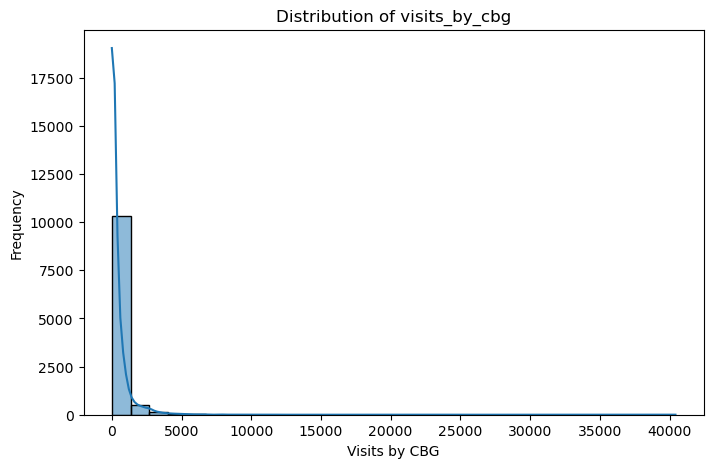

In [57]:
## check data distribution : especially visits_by_cbg

# Create histogram using Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(ddf['visits_by_cbg'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of visits_by_cbg")
plt.xlabel("Visits by CBG")
plt.ylabel("Frequency")
plt.show()

## a)logarithmic transformation

In [58]:
## Log Transformation (Best for Right-Skewed Data)
ddf_log = ddf.copy()

# Apply log transformation (adding 1 to avoid log(0))
ddf_log['log_visits'] = np.log1p(ddf_log['visits_by_cbg'])

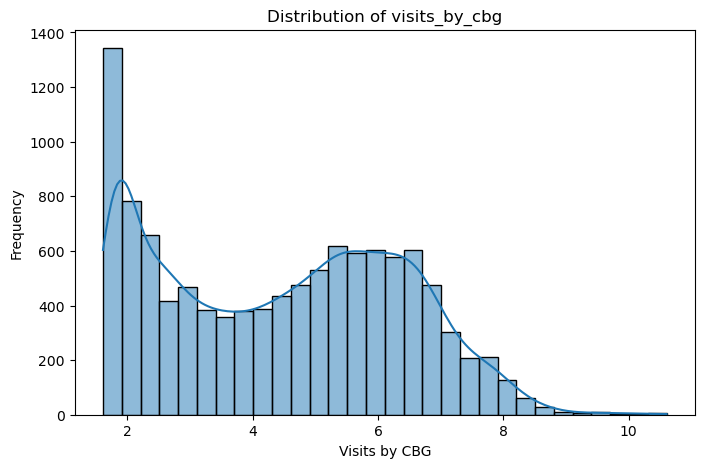

In [59]:
# Create histogram using Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(ddf_log['log_visits'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of visits_by_cbg")
plt.xlabel("Visits by CBG")
plt.ylabel("Frequency")
plt.show()

## b) Robust scaling transformation

In [60]:
from sklearn.preprocessing import RobustScaler
## Robust Scaling (Best for Data with Extreme Outliers)
ddf_rs = ddf.copy()

scaler = RobustScaler()
ddf_rs['robust_visits'] = scaler.fit_transform(ddf_rs[['visits_by_cbg']])

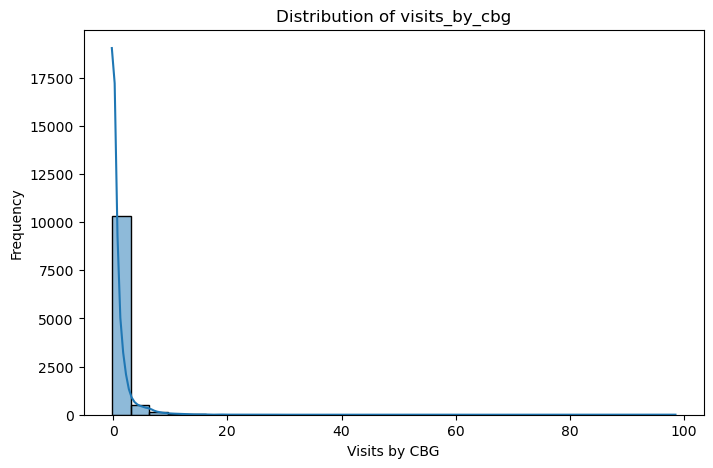

In [61]:
# Create histogram using Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(ddf_rs['robust_visits'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of visits_by_cbg")
plt.xlabel("Visits by CBG")
plt.ylabel("Frequency")
plt.show()

## c) Power transformation (Box - Cox)

In [62]:
from sklearn.preprocessing import PowerTransformer
## Power Transformations (Box-Cox or Yeo-Johnson)
ddf_cox = ddf.copy()

scaler = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if all values > 0
ddf_cox['cox_visits'] = scaler.fit_transform(ddf_cox[['visits_by_cbg']])


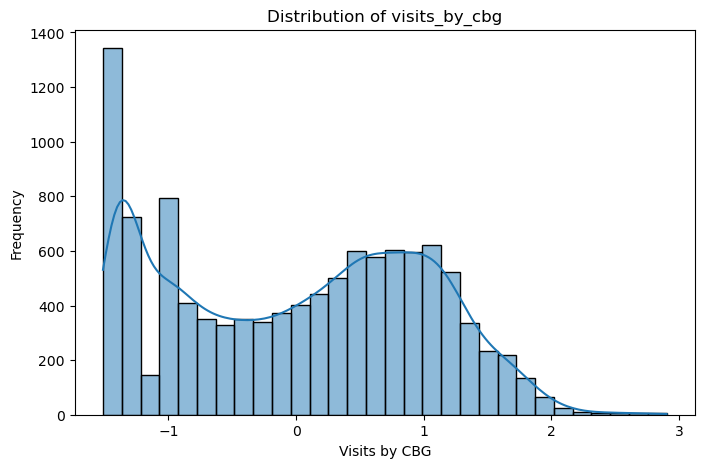

In [63]:
# Create histogram using Seaborn
plt.figure(figsize=(8, 5))
sns.histplot(ddf_cox['cox_visits'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of visits_by_cbg")
plt.xlabel("Visits by CBG")
plt.ylabel("Frequency")
plt.show()

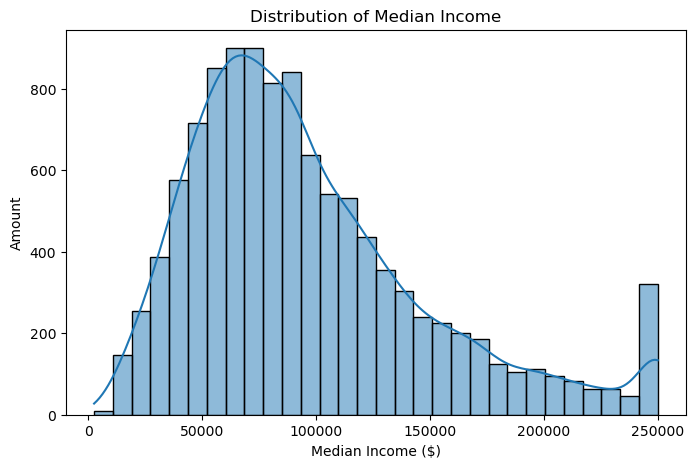

In [64]:
# Create histogram using Seaborn to check distribution of median income
plt.figure(figsize=(8, 5))
sns.histplot(ddf_cox['median_income'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of Median Income")
plt.xlabel("Median Income ($)")
plt.ylabel("Amount")
plt.show()

## Decision to adopt Logarithmic Transformation as it fits our data compared to other scaling

<p>I compared Box-Cox Transformation: Power Transformation over Logarithmic</p>

In [65]:
## Import sklearn library

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [66]:
## # Make a copy of the dataset
ddf_copy = ddf.copy()

scaler = PowerTransformer(method='yeo-johnson')  # Use 'box-cox' if all values > 0
ddf_copy['power_visits'] = scaler.fit_transform(ddf_copy[['visits_by_cbg']])
ddf_copy['log_visits'] = np.log1p(ddf_copy['visits_by_cbg'])
ddf_copy['log_distance'] = np.log1p(ddf_copy['distance_from_home'])
ddf_copy['log_dwell'] = np.log1p(ddf_copy['median_dwell'])
ddf_copy['power_dwell'] = scaler.fit_transform(ddf_copy[['median_dwell']])

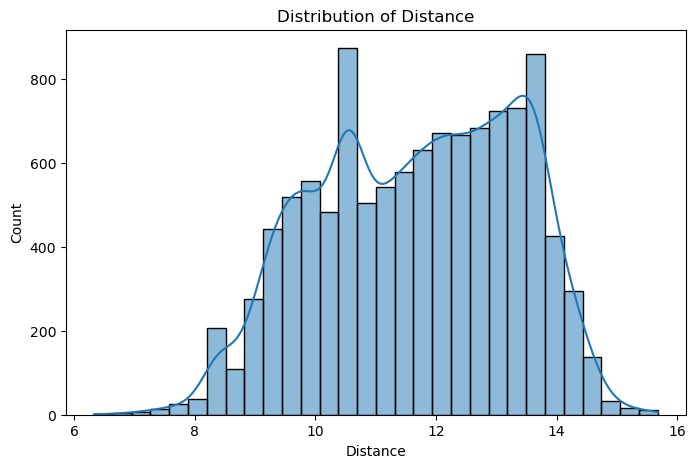

In [67]:
# Create histogram using Seaborn to check distribution of median income
plt.figure(figsize=(8, 5))
sns.histplot(ddf_copy['log_distance'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show()

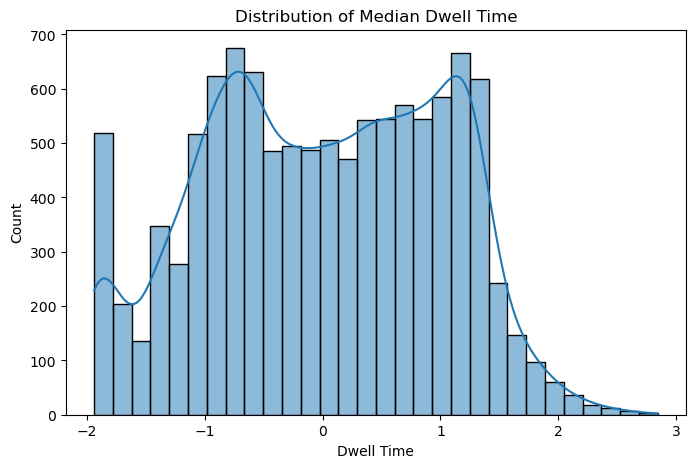

In [68]:
# Create histogram using Seaborn to check distribution of median income
plt.figure(figsize=(8, 5))
sns.histplot(ddf_copy['power_dwell'], bins=30, kde=True)  # kde=True adds a density curve
plt.title("Distribution of Median Dwell Time")
plt.xlabel("Dwell Time")
plt.ylabel("Count")
plt.show()

## Transforming socioeconomic variables

<p>Logarithmic transform applied to median household income</p>

<p>Convert to decimal pcts columns</p>

In [69]:
## Normalize the pct_ columns : best recommended for percentage values

from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score standardization on 'median_income'
#ddf_copy['income_zscore'] = scaler.fit_transform(ddf_copy[['median_income']])
ddf_copy['log_income'] = np.log1p(ddf_copy['median_income'])

percentage_cols = [col for col in ddf.columns if col.startswith("pct_")]

# Convert percentage columns to decimal (0-1 scale), but keep 0s unchanged
for col in percentage_cols:
    ddf_copy[col] = ddf_copy[col].apply(lambda x: x / 100 if x > 0 else x)

In [70]:
ddf_copy

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_emp,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income
16,040130304021,arizona,6,97.0,12863.0,162802.0,0.5550,0.4450,0.9891,0.0000,...,0.9654,1.0000,0.0000,0.0000,-1.320328,1.945910,9.462188,4.584967,-0.644426,12.000296
17,040130405024,arizona,8,140.0,8396.0,63929.0,0.4752,0.5248,0.9407,0.0000,...,0.9731,0.8969,0.0000,0.1031,-1.177987,2.197225,9.035630,4.948760,-0.487462,11.065544
18,040130608022,arizona,5,81.0,11827.0,78190.0,0.4749,0.5251,0.4821,0.0452,...,0.9237,0.9917,0.0083,0.0000,-1.408288,1.791759,9.378225,4.406719,-0.718739,11.266910
19,040130610112,arizona,5,31.0,18076.0,82083.0,0.4456,0.5544,0.3715,0.0747,...,0.9258,1.0000,0.0000,0.0000,-1.408288,1.791759,9.802396,3.465736,-1.084471,11.315498
20,040130610131,arizona,13,111.0,29995.0,116667.0,0.4710,0.5290,0.5803,0.1845,...,0.9385,1.0000,0.0000,0.0000,-0.930896,2.639057,10.308819,4.718499,-0.587648,11.667088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20886,482015557011,texas,171,1022.0,160472.0,160404.0,0.5343,0.4657,0.6515,0.2030,...,0.9920,0.9925,0.0075,0.0000,0.398530,5.147494,11.985881,6.930495,0.506668,11.985457
20887,482015557012,texas,212,995.0,143021.0,126484.0,0.4818,0.5182,0.7522,0.0192,...,0.9268,1.0000,0.0000,0.0000,0.506286,5.361292,11.870754,6.903747,0.491526,11.747879
20888,482015560001,texas,67,844.0,120412.0,36964.0,0.5691,0.4309,0.7399,0.2320,...,0.9619,1.0000,0.0000,0.0000,-0.079098,4.219508,11.698683,6.739337,0.399566,10.517727
20889,482015560002,texas,76,838.0,120179.0,105493.0,0.4523,0.5477,0.5745,0.2699,...,0.9372,1.0000,0.0000,0.0000,-0.014176,4.343805,11.696746,6.732211,0.395623,11.566409


## Done with data wrangling: Now move to analysis

# Question 1: Identifiable Patterns in Park Visitations Across States & Cities
<p>What identifiable patterns emerge in park visitations when analyzed at a city-wide scale using available human mobility data, and are these patterns consistent across different cities?</p>

## Between States Analysis

In [71]:
ddf_state = ddf_copy.copy()

In [72]:
# cross state analysis

state_visits = ddf_state.groupby('state')['visits_by_cbg'].agg(['mean', 'median', 'std']).reset_index()

In [73]:
state_visits

,state,mean,median,std
0,arizona,20.301613,9.0,29.696434
1,california,243.818112,29.5,408.545550
2,illinois,16.632750,10.0,35.092336
3,new york,747.043164,277.0,1837.218658
4,pennsylvania,396.259096,222.0,509.715910
5,texas,19.377698,10.0,30.505427


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'arizona'),
  Text(1, 0, 'california'),
  Text(2, 0, 'illinois'),
  Text(3, 0, 'new york'),
  Text(4, 0, 'pennsylvania'),
  Text(5, 0, 'texas')])

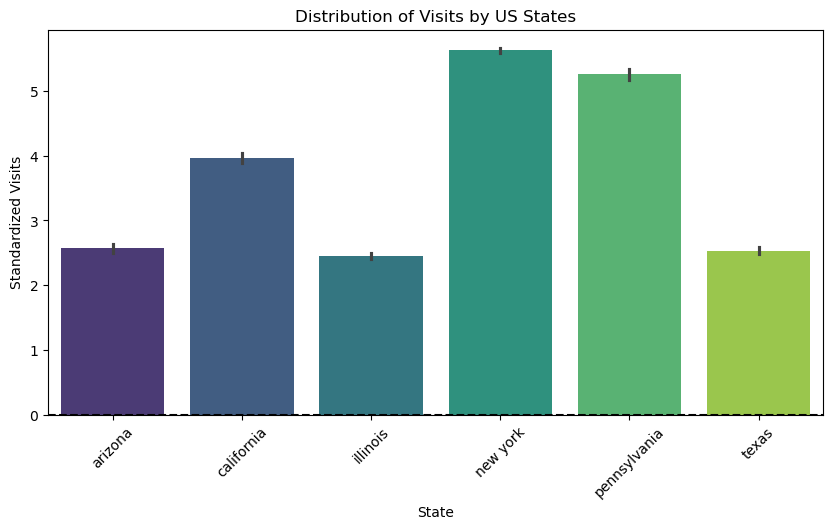

In [74]:
# Plot visit distributions
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='state', y='log_visits', data=ddf_state, palette='viridis', hue='state')
# Add a horizontal baseline at y=0
plt.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
plt.xlabel("State")
plt.ylabel("Standardized Visits")
plt.title("Distribution of Visits by US States")
plt.xticks(rotation=45)

In [75]:
ddf_state.columns

Index(['visitor_home_cbg', 'state', 'visits_by_cbg', 'median_dwell',
       'distance_from_home', 'median_income', 'pct_male', 'pct_female',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_young',
       'pct_adult', 'pct_elderly', 'pct_low_edu', 'pct_high_edu',
       'pct_short_comute', 'pct_long_comute', 'pct_unemp', 'pct_emp',
       'pct_car', 'pct_public_trans', 'pct_0car', 'power_visits', 'log_visits',
       'log_distance', 'log_dwell', 'power_dwell', 'log_income'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Between Socioeconomic Factors and Park Visits')

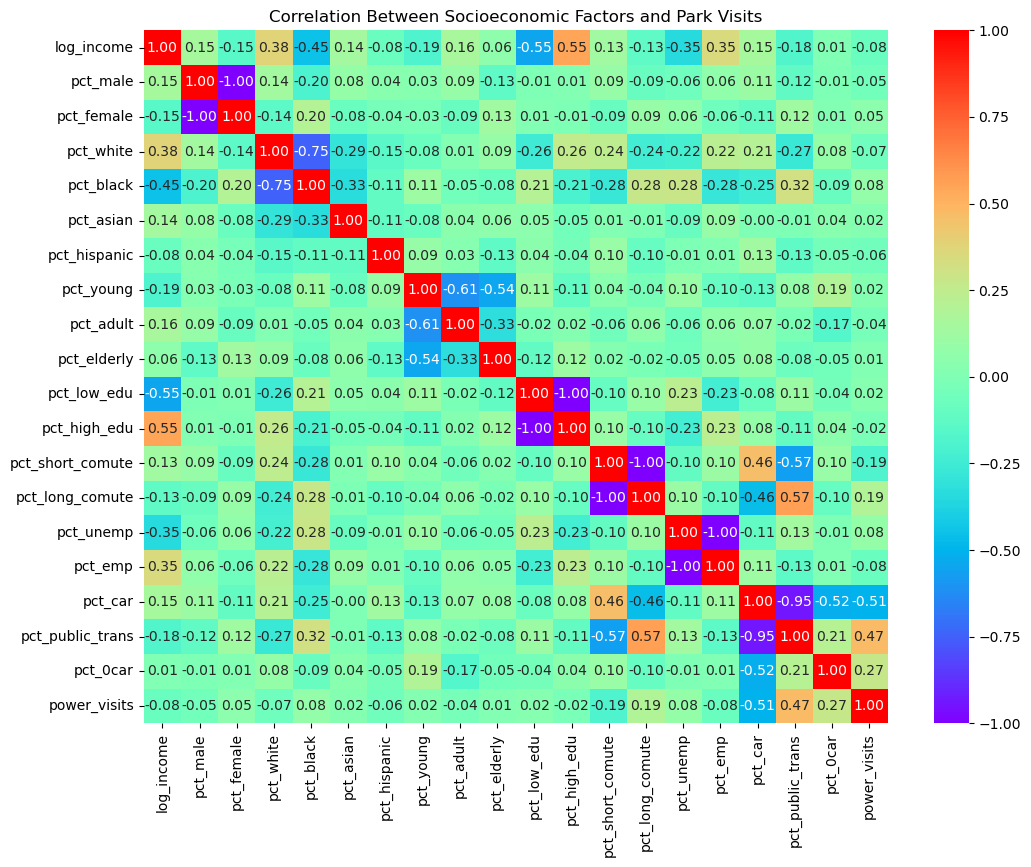

In [76]:
# Step 1: Compute correlations between socioeconomic factors and park visits
socioeconomic_factors = ['log_income', 'pct_male', 'pct_female',
                         'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic','pct_young', 'pct_adult',
                         'pct_elderly', 'pct_low_edu', 'pct_high_edu', 'pct_short_comute',
                         'pct_long_comute', 'pct_unemp', 'pct_emp', 'pct_car',
                         'pct_public_trans', 'pct_0car']
correlation_matrix = ddf_state[socioeconomic_factors + ['power_visits']].corr()

# Plot heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow', fmt=".2f")
plt.title("Correlation Between Socioeconomic Factors and Park Visits")

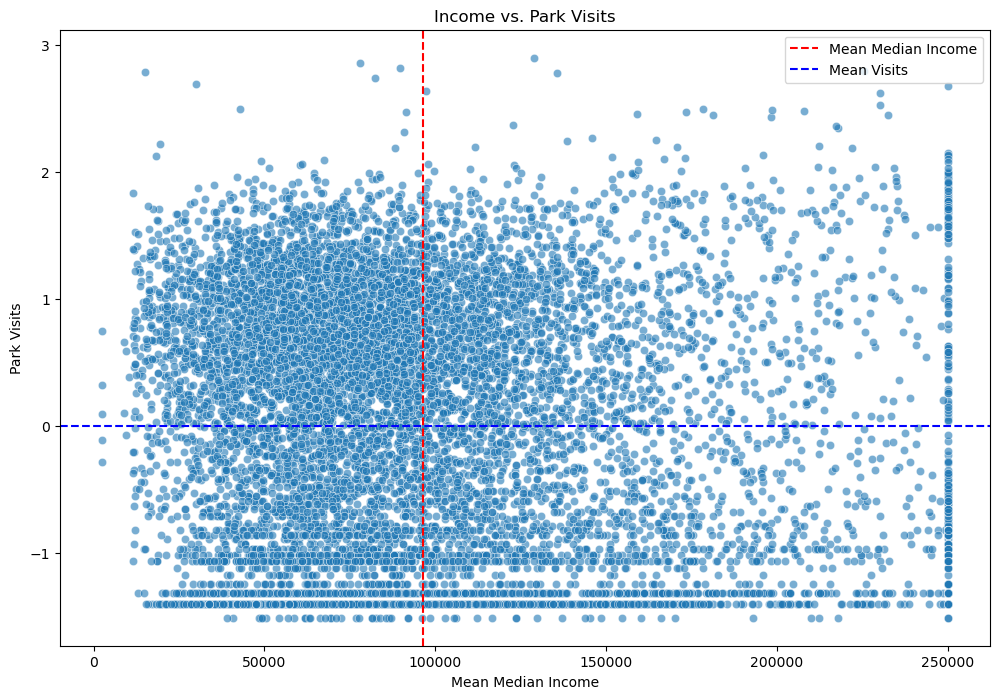

In [77]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=ddf_state['median_income'], y=ddf_state['power_visits'], alpha=0.6)
plt.axvline(ddf_state['median_income'].mean(), color='red', linestyle='--', label='Mean Median Income')
plt.axhline(ddf_state['power_visits'].mean(), color='blue', linestyle='--', label='Mean Visits')
plt.title("Income vs. Park Visits")
plt.xlabel("Mean Median Income")
plt.ylabel("Park Visits")
plt.legend()

# Question 2: Socioeconomic Predictors of Park Accessibility
<p> How do socioeconomic predictors empirically demonstrate observed disparities, revealing inequities in urban park accessibility?</p>

<p>Here I will be using ANOVA and Man U Whitney Test for significance of visits and socioeconomic variables</p>

<p>Variables to check include</p>
<p>1. Income</p>
<p>2. Race</p>
<p>3. Gender</p>
<p>4. Age</p>
<p>5. Employment</p>
<p>6. Mode of Transportation</p>
<p>7. Commute time</p>

<p>NB: Make a copy of each city df</p>

In [78]:
ddf_state.shape

(11067, 30)

In [79]:
import scipy.stats as stats
import ace_tools_open as tools
# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

# Assign each row to a dominant racial group (whichever percentage is highest)
ddf_copy['dominant_race'] = ddf_copy[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[ddf_copy[ddf_copy['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [80]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(ddf_copy['log_visits'], ddf_copy['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


Tukey HSD Post-hoc Test
         group1        group2  meandiff   p-adj   lower   upper  reject
0     pct_asian     pct_black    0.3863  0.0000  0.2128  0.5598    True
1     pct_asian  pct_hispanic   -0.4418  0.0086 -0.8012 -0.0824    True
2     pct_asian     pct_white    0.0485  0.8496 -0.1052  0.2021   False
3     pct_black  pct_hispanic   -0.8281  0.0000 -1.1729 -0.4833    True
4     pct_black     pct_white   -0.3378  0.0000 -0.4532 -0.2225    True
5  pct_hispanic     pct_white    0.4903  0.0010  0.1550  0.8255    True


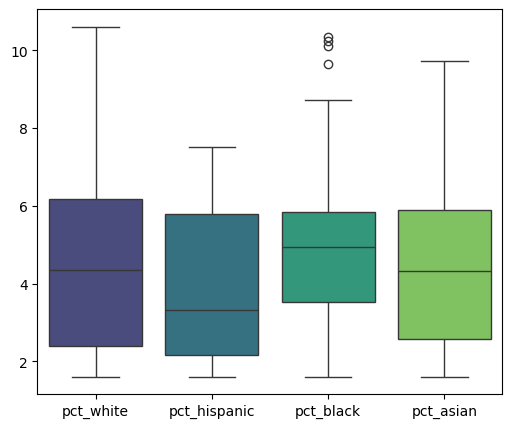

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming df_copy is your DataFrame and it has columns 'log_visits' and 'dominant_rate'
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(ddf_copy['log_visits'], ddf_copy['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
print("Tukey HSD Post-hoc Test")
print(tukey_df)

# Plotting the boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(x='dominant_race', y='log_visits', data=ddf_copy, palette='viridis', hue='dominant_race')
plt.title('')
plt.xlabel('')
plt.ylabel('')
#plt.savefig('pct_racial_group.png', dpi=300)
plt.show()

<p>Income</p>

In [82]:
ddf_copy_income = ddf_copy[['median_income','log_visits']]

In [83]:
ddf_copy_income_rank = ddf_copy_income.sort_values('median_income')

In [84]:
pct_low_incomex = ddf_copy_income_rank.head(3689)
pct_median_incomex = ddf_copy_income_rank.iloc[3690:7378]
pct_high_incomex = ddf_copy_income_rank.iloc[7379:11067]

In [85]:
# Step 1: Combine data into a single DataFrame
combined_data = pd.DataFrame({
    'log_visits': pd.concat([
        pct_low_incomex['log_visits'], 
        pct_median_incomex['log_visits'], 
        pct_high_incomex['log_visits']
    ], ignore_index=True),
    'income_group': ['pct_low_incomex'] * len(pct_low_incomex) + 
                    ['pct_median_incomex'] * len(pct_median_incomex) + 
                    ['pct_high_incomex'] * len(pct_high_incomex)
})

# Step 2: Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(endog=combined_data['log_visits'],
                                  groups=combined_data['income_group'],
                                  alpha=0.05)

# Display the results
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1            group2       meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
pct_high_incomex    pct_low_incomex    0.264    0.0  0.1588 0.3691   True
pct_high_incomex pct_median_incomex   0.1854 0.0001  0.0802 0.2906   True
 pct_low_incomex pct_median_incomex  -0.0786 0.1864 -0.1837 0.0266  False
-------------------------------------------------------------------------


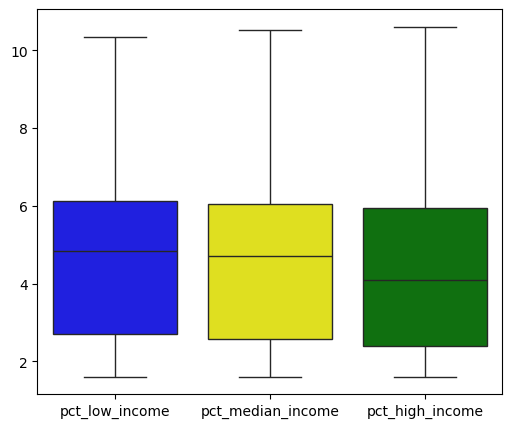

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a color palette for each income group
income_palette = {'pct_low_incomex': 'blue', 'pct_median_incomex': 'yellow', 'pct_high_incomex': 'green'}

# Create a boxplot for log-transformed visits by income group with custom colors
plt.figure(figsize=(6, 5))
sns.boxplot(x='income_group', y='log_visits', data=combined_data, palette=income_palette, hue='income_group')

# Add title and labels
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Ensure the x-axis labels are displayed correctly
plt.xticks(ticks=[0, 1, 2], labels=['pct_low_income', 'pct_median_income', 'pct_high_income'])

# Save the plot
#plt.savefig('pct_income_group.png', dpi=300)

# Show the plot
plt.show()

In [87]:
# check mean visits across groups

# Calculate the mean of visits_by_cbg for areas with high and low education percentages
pct_mean_visits_low_income = pct_low_incomex['log_visits'].max()
pct_mean_visits_median_income = pct_median_incomex['log_visits'].max()
pct_mean_visits_high_income = pct_high_incomex['log_visits'].max()

print(f'Mean visits for pct_low_income: {pct_mean_visits_low_income}')
print(f'Mean visits for pct_medium_income: {pct_mean_visits_median_income}')
print(f'Mean visits for pct_high_income: {pct_mean_visits_high_income}')

Mean visits for pct_low_income: 10.340935706497342
Mean visits for pct_medium_income: 10.509632446974212
Mean visits for pct_high_income: 10.607154208886223


## Cross cities Analysis

## 1) New York

In [88]:
NY_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith(("36085","36047","36081","36061","36005"))]

In [89]:
NY_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
8522,360050002001,new york,210,523.0,569960.0,123208.0,0.5727,0.4273,0.3181,0.6287,...,0.6976,0.2292,0.0731,0.501549,5.351858,13.253323,6.261492,0.142887,11.721637,pct_black
8523,360050002002,new york,767,1552.0,1260114.0,115764.0,0.5211,0.4789,0.1716,0.7959,...,0.4489,0.3694,0.1817,1.135247,6.643790,14.046714,7.347944,0.749746,11.659318,pct_black
8524,360050002003,new york,390,2330.0,846093.0,81622.0,0.4919,0.5081,0.4444,0.2483,...,0.4248,0.5752,0.0000,0.807862,5.968708,13.648386,7.754053,0.998850,11.309866,pct_white
8526,360050004002,new york,606,2060.0,1160996.0,71230.0,0.5185,0.4815,0.1214,0.8148,...,0.6302,0.3698,0.0000,1.022074,6.408529,13.964790,7.630947,0.921983,11.173683,pct_black
8527,360050004003,new york,2031,5431.0,2240951.0,129469.0,0.4934,0.5066,0.2243,0.6716,...,0.6392,0.3608,0.0000,1.593074,7.616776,14.622411,8.600063,1.560709,11.771204,pct_black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15536,360850319012,new york,542,810.0,217009.0,93547.0,0.5317,0.4683,0.2102,0.4965,...,0.5766,0.3546,0.0688,0.968134,6.297109,12.287699,6.698268,0.376892,11.446230,pct_black
15537,360850319021,new york,300,876.0,101201.0,17052.0,0.3498,0.6502,0.3721,0.5986,...,0.4307,0.5693,0.0000,0.678804,5.707110,11.524874,6.776507,0.420190,9.744081,pct_black
15538,360850319022,new york,700,1325.0,665717.0,160500.0,0.4580,0.5420,0.1202,0.8074,...,0.4797,0.4830,0.0372,1.091451,6.552508,13.408621,7.189922,0.656220,11.986055,pct_black
15539,360850319023,new york,291,793.0,187778.0,125217.0,0.5772,0.4228,0.3157,0.5759,...,0.7333,0.2225,0.0443,0.663748,5.676754,12.143021,6.677083,0.365242,11.737811,pct_black


## ANOVA Test : New York

In [90]:
NY_df_anova = NY_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

# Assign each row to a dominant racial group (whichever percentage is highest)
NY_df_anova['dominant_race'] = NY_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [91]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(NY_df_anova['log_visits'], NY_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>NYC Income</p>

In [92]:
NY_df_income = NY_df[['median_income','log_visits']]

In [93]:
NY_df_income_rank = NY_df_income.sort_values('median_income')

In [94]:
pct_low_income = NY_df_income_rank.head(1614)
pct_median_income = NY_df_income_rank.iloc[1615:3228]
pct_high_income = NY_df_income_rank.iloc[3228:4842]

In [95]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income['log_visits'], pct_median_income['log_visits'],pct_high_income['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 9.946019051849651
ANOVA p-value: 4.890515340844613e-05


<p>Gender</p>

In [96]:
NY_df_anova = NY_df.copy()

# Define gender group column names
gender_columns = ['pct_male', 'pct_female']

# Assign each row to a dominant gender group (whichever percentage is highest)
NY_df_anova['dominant_gender'] = NY_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [97]:
NY_df_anova = NY_df.copy()

# Define age group column names
age_columns = ['pct_young', 'pct_adult','pct_elderly']

# Assign each row to a dominant age group (whichever percentage is highest)
NY_df_anova['dominant_age'] = NY_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [98]:
NY_df_anova = NY_df.copy()

# Define education group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant employment group (whichever percentage is highest)
NY_df_anova['dominant_edu'] = NY_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [99]:
NY_df_anova = NY_df.copy()

# Define employment group column names
employment_columns = ['pct_unemp', 'pct_emp']

# Assign each row to a dominant employment group (whichever percentage is highest)
NY_df_anova['dominant_employment'] = NY_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [100]:
NY_df.columns

Index(['visitor_home_cbg', 'state', 'visits_by_cbg', 'median_dwell',
       'distance_from_home', 'median_income', 'pct_male', 'pct_female',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_young',
       'pct_adult', 'pct_elderly', 'pct_low_edu', 'pct_high_edu',
       'pct_short_comute', 'pct_long_comute', 'pct_unemp', 'pct_emp',
       'pct_car', 'pct_public_trans', 'pct_0car', 'power_visits', 'log_visits',
       'log_distance', 'log_dwell', 'power_dwell', 'log_income',
       'dominant_race'],
      dtype='object')

<p>commute</p>

In [101]:
NY_df_anova = NY_df.copy()

# Define commute group column names
commute_columns = ['pct_short_comute', 'pct_long_comute']

# Assign each row to a dominant commute group (whichever percentage is highest)
NY_df_anova['dominant_employment'] = NY_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_employment'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>transport</p>

In [102]:
NY_df_anova = NY_df.copy()

# Define transport group column names
transport_columns = ['pct_car', 'pct_public_trans', 'pct_0car']

# Assign each row to a dominant transport group (whichever percentage is highest)
NY_df_anova['dominant_transport'] = NY_df_anova[transport_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[NY_df_anova[NY_df_anova['dominant_transport'] == commute]['log_visits'] for commute in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


## 2) Los Angeles

In [103]:
# Filter visitor_home_cbg that starts with "06" (LA Census Blocks)
LA_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("06037")]

In [104]:
LA_df.loc[:, 'state'] = LA_df['state'].replace('california', 'Los Angeles')

In [105]:
LA_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
1675,060371021041,Los Angeles,5,34.0,14737.0,109762.0,0.4092,0.5908,0.8003,0.0279,...,0.9009,0.0439,0.0552,-1.408288,1.791759,9.598184,3.555348,-1.051485,11.606079,pct_white
1676,060371021042,Los Angeles,5,6.0,19724.0,93750.0,0.4791,0.5209,0.7210,0.0000,...,1.0000,0.0000,0.0000,-1.408288,1.791759,9.889642,1.945910,-1.590605,11.448398,pct_white
1677,060371048221,Los Angeles,6,34.0,4223.0,48278.0,0.4827,0.5173,0.8665,0.0065,...,0.8483,0.1263,0.0255,-1.320328,1.945910,8.348538,3.555348,-1.051485,10.784752,pct_white
1678,060371066431,Los Angeles,23,37.0,65276.0,222850.0,0.4902,0.5098,0.5644,0.0369,...,0.9652,0.0348,0.0000,-0.634837,3.178054,11.086395,3.637586,-1.020882,12.314259,pct_white
1679,060371066452,Los Angeles,5,14.0,13785.0,152866.0,0.4415,0.5585,0.8275,0.0000,...,0.9887,0.0113,0.0000,-1.408288,1.791759,9.531409,2.708050,-1.348938,11.937324,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,060379203281,Los Angeles,11,96.0,35562.0,117933.0,0.5552,0.4448,0.7941,0.0488,...,0.9934,0.0066,0.0000,-1.016650,2.484907,10.479061,4.574711,-0.648747,11.677880,pct_white
2452,060379203291,Los Angeles,5,31.0,18076.0,95596.0,0.5221,0.4779,0.8888,0.0000,...,0.9351,0.0098,0.0551,-1.408288,1.791759,9.802396,3.465736,-1.084471,11.467897,pct_white
2453,060379203293,Los Angeles,5,20.0,13445.0,104612.0,0.5841,0.4159,0.7864,0.0406,...,0.9869,0.0131,0.0000,-1.408288,1.791759,9.506437,3.044522,-1.234613,11.558023,pct_white
2454,060379203381,Los Angeles,11,141.0,23281.0,245185.0,0.4322,0.5678,0.7299,0.0295,...,1.0000,0.0000,0.0000,-1.016650,2.484907,10.055436,4.955827,-0.484341,12.409772,pct_white


In [106]:
LA_df_anova = LA_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.3:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

LA_df_anova['dominant_race'] = LA_df_anova.apply(assign_race, axis=1)
# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_race'] = LA_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [107]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(LA_df_anova['log_visits'], LA_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [108]:
LA_df_income = LA_df[['median_income','log_visits']]

In [109]:
LA_df_income_rank = LA_df_income.sort_values('median_income')

In [110]:
pct_low_income1 = LA_df_income_rank.head(242)
pct_median_income1 = LA_df_income_rank.iloc[242:484]
pct_high_income1 = LA_df_income_rank.iloc[484:726]

In [111]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income1['log_visits'], pct_median_income1['log_visits'],pct_high_income1['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 6.454065851880041
ANOVA p-value: 0.0016663353208717375


<p>gender</p>

In [112]:
LA_df_anova = LA_df.copy()

# Define gender group column names
gender_columns = ['pct_male','pct_female']

# Assign each row to a dominant gender group (whichever percentage is highest)
LA_df_anova['dominant_gender'] = LA_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [113]:
LA_df_anova = LA_df.copy()

# Define age group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant age group (whichever percentage is highest)
LA_df_anova['dominant_age'] = LA_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [114]:
LA_df_anova = LA_df.copy()

# Define education group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant education group (whichever percentage is highest)
LA_df_anova['dominant_edu'] = LA_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>employment</p>

In [115]:
LA_df_anova = LA_df.copy()

# Define employment group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

LA_df_anova['dominant_employment'] = LA_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>commute</p>

In [116]:
LA_df_anova = LA_df.copy()

# Define commute group column names
commute_columns = ['pct_long_comute', 'pct_short_comute']

# def assign_employment(row):
#     if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
#         return 'pct_unemp'
#     else:
#         return row[employment_columns].idxmax()

# LA_df_anova['dominant_employment'] = LA_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant employment group (whichever percentage is highest)
LA_df_anova['dominant_comute'] = LA_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_comute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>transport</p>

In [117]:
LA_df_anova = LA_df.copy()

# Define transport group column names
transport_columns = ['pct_car', 'pct_0car','pct_public_trans']

# def assign_employment(row):
#     if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
#         return 'pct_unemp'
#     else:
#         return row[employment_columns].idxmax()

# LA_df_anova['dominant_employment'] = LA_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant transport group (whichever percentage is highest)
LA_df_anova['dominant_transport'] = LA_df_anova[transport_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[LA_df_anova[LA_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


## 3) Chicago

In [118]:
IL_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("17031")]

In [119]:
IL_df.loc[:,'state'] = IL_df['state'].replace('illinois', 'chicago')

In [120]:
IL_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
6677,170310102011,chicago,11,179.0,6059.0,74563.0,0.4892,0.5108,0.3688,0.2351,...,0.7242,0.2150,0.0608,-1.016650,2.484907,8.709465,5.192957,-0.377979,11.219413,pct_white
6678,170310103001,chicago,6,45.0,37126.0,71250.0,0.5826,0.4174,0.8162,0.1526,...,0.5000,0.4556,0.0444,-1.320328,1.945910,10.522100,3.828641,-0.948547,11.173964,pct_white
6679,170310103004,chicago,5,14.0,43538.0,70956.0,0.4929,0.5071,0.5942,0.2904,...,0.7025,0.2975,0.0000,-1.408288,1.791759,10.681412,2.708050,-1.348938,11.169829,pct_white
6681,170310105013,chicago,5,16.0,4424.0,58237.0,0.4544,0.5456,0.8451,0.0796,...,0.6939,0.2854,0.0207,-1.408288,1.791759,8.395026,2.833213,-1.306977,10.972293,pct_white
6682,170310105021,chicago,11,56.0,74791.0,62045.0,0.4209,0.5791,0.6215,0.2725,...,0.3387,0.4624,0.1988,-1.016650,2.484907,11.222466,4.043051,-0.865263,11.035631,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8020,170318431002,chicago,5,31.0,38696.0,84563.0,0.4760,0.5240,0.4781,0.4898,...,0.6763,0.2885,0.0353,-1.408288,1.791759,10.563517,3.465736,-1.084471,11.345264,pct_black
8021,170318433001,chicago,5,95.0,8137.0,41250.0,0.5013,0.4987,0.1243,0.8055,...,0.6972,0.2592,0.0436,-1.408288,1.791759,9.004300,4.564348,-0.653108,10.627431,pct_black
8022,170318436001,chicago,10,45.0,82234.0,57292.0,0.3456,0.6544,0.0869,0.8990,...,0.7702,0.1957,0.0342,-1.065268,2.397895,11.317336,3.828641,-0.948547,10.955934,pct_black
8024,170318437001,chicago,38,308.0,172620.0,190893.0,0.3843,0.6157,0.6937,0.0511,...,0.6989,0.3011,0.0000,-0.373120,3.663562,12.058854,5.733341,-0.123353,12.159474,pct_white


In [121]:
IL_df_anova = IL_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.3:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

IL_df_anova['dominant_race'] = IL_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#IL_df_anova['dominant_race'] = IL_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [122]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(IL_df_anova['log_visits'], IL_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [123]:
IL_df_income = IL_df[['median_income','log_visits']]

In [124]:
IL_df_income_rank = IL_df_income.sort_values('median_income')

In [125]:
pct_low_income2 = IL_df_income_rank.head(419)
pct_median_income2 = IL_df_income_rank.iloc[419:838]
pct_high_income2 = IL_df_income_rank.iloc[838:1258]

In [126]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income2['log_visits'], pct_median_income2['log_visits'],pct_high_income2['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 4.795140626418011
ANOVA p-value: 0.008421965726250973


<p>gender</p>

In [127]:
IL_df_anova = IL_df.copy()

# Define income group column names
gender_columns = ['pct_male','pct_female']

# Assign each row to a dominant income group (whichever percentage is highest)
IL_df_anova['dominant_gender'] = IL_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [128]:
IL_df_anova = IL_df.copy()

# Define age group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant age group (whichever percentage is highest)
IL_df_anova['dominant_age'] = IL_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [129]:
IL_df_anova = IL_df.copy()

# Define education group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant education group (whichever percentage is highest)
IL_df_anova['dominant_edu'] = IL_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>employment</p>

In [130]:
IL_df_anova = IL_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

IL_df_anova['dominant_employment'] = IL_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>commute</p>

In [131]:
IL_df_anova = IL_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
IL_df_anova['dominant_commute'] = IL_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>transport</p>

In [132]:
IL_df_anova = IL_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
IL_df_anova['dominant_transport'] = IL_df_anova[transport_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[IL_df_anova[IL_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


## 4) Houston

In [133]:
HT_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("48201")]

In [134]:
HT_df.loc[:,'state'] = HT_df['state'].replace('texas', 'Houston')

In [135]:
HT_df.sample(20)

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
20548,482013432001,Houston,5,116.0,15320.0,130735.0,0.5270,0.4730,0.9703,0.0207,...,1.0000,0.0000,0.0000,-1.408288,1.791759,9.636980,4.762174,-0.568869,11.780935,pct_white
20465,482013303012,Houston,10,232.0,32713.0,77981.0,0.5055,0.4945,0.4066,0.4715,...,1.0000,0.0000,0.0000,-1.065268,2.397895,10.395558,5.451038,-0.258540,11.264233,pct_black
20366,482012311003,Houston,11,126.0,22410.0,24718.0,0.4901,0.5099,0.7954,0.2046,...,0.9910,0.0000,0.0090,-1.016650,2.484907,10.017307,4.844187,-0.533323,10.115327,pct_white
20510,482013327002,Houston,10,241.0,31657.0,66117.0,0.5020,0.4980,0.9577,0.0423,...,0.8842,0.0000,0.1158,-1.065268,2.397895,10.362746,5.488938,-0.240670,11.099196,pct_white
20467,482013303032,Houston,25,596.0,77266.0,49267.0,0.3927,0.6073,0.5405,0.3844,...,1.0000,0.0000,0.0000,-0.591368,3.258097,11.255022,6.391917,0.211416,10.805030,pct_white
20782,482015339021,Houston,5,87.0,11874.0,33906.0,0.3892,0.6108,0.3529,0.5722,...,0.9475,0.0525,0.0000,-1.408288,1.791759,9.382191,4.477337,-0.689498,10.431377,pct_black
20516,482013332012,Houston,5,116.0,14908.0,58788.0,0.5878,0.4122,0.7422,0.2578,...,0.6804,0.3196,0.0000,-1.408288,1.791759,9.609720,4.762174,-0.568869,10.981710,pct_white
20684,482014536011,Houston,6,51.0,9321.0,28194.0,0.4855,0.5145,0.2970,0.2794,...,0.9865,0.0135,0.0000,-1.320328,1.945910,9.140132,3.951244,-0.901201,10.246900,pct_asian
20405,482013102001,Houston,5,81.0,12395.0,125827.0,0.3947,0.6053,0.5544,0.3079,...,0.8427,0.1503,0.0070,-1.408288,1.791759,9.425129,4.406719,-0.718739,11.742671,pct_white
20469,482013304001,Houston,10,235.0,30618.0,58333.0,0.4084,0.5916,0.5800,0.4200,...,1.0000,0.0000,0.0000,-1.065268,2.397895,10.329376,5.463832,-0.252517,10.973940,pct_white


In [136]:
HT_df_anova = HT_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.2:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

HT_df_anova['dominant_race'] = HT_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#HT_df_anova['dominant_race'] = HT_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [137]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(HT_df_anova['log_visits'], HT_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [138]:
HT_df_income = HT_df[['median_income','log_visits']]

In [139]:
HT_df_income_rank = HT_df_income.sort_values('median_income')

In [140]:
pct_low_income3 = HT_df_income_rank.head(6)
pct_median_income3 = HT_df_income_rank.iloc[6:12]
pct_high_income3 = HT_df_income_rank.iloc[13:20]

In [141]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income3['log_visits'], pct_median_income3['log_visits'],pct_high_income3['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 0.9842127322183661
ANOVA p-value: 0.3952571015250955


<p>gender</p>

In [142]:
HT_df_anova = HT_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
HT_df_anova['dominant_gender'] = HT_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [143]:
HT_df_anova = HT_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
HT_df_anova['dominant_age'] = HT_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [144]:
HT_df_anova = HT_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
HT_df_anova['dominant_edu'] = HT_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [145]:
HT_df_anova = HT_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

HT_df_anova['dominant_employment'] = HT_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Commute</p>

In [146]:
HT_df_anova = HT_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
HT_df_anova['dominant_commute'] = HT_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [147]:
HT_df_anova = HT_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
HT_df_anova['dominant_transport'] = HT_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[HT_df_anova[HT_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = HT_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[HT_df_anova[HT_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [148]:
print(HT_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car    518
Name: count, dtype: int64


## 5) San Diego

In [149]:
SD_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("06073")]

In [150]:
SD_df.loc[:,'state'] = SD_df['state'].replace('california', 'San Diego')

In [151]:
SD_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
3406,060730001001,San Diego,792,3934.0,1012789.0,199643.0,0.4692,0.5308,0.8642,0.0000,...,0.9672,0.0000,0.0328,1.150581,6.675823,13.828219,8.277666,1.339485,12.204291,pct_white
3407,060730001002,San Diego,738,3668.0,920407.0,174375.0,0.4957,0.5043,0.8299,0.0266,...,1.0000,0.0000,0.0000,1.116797,6.605298,13.732572,8.207674,1.292636,12.068969,pct_white
3408,060730002011,San Diego,494,3001.0,703726.0,159250.0,0.5351,0.4649,0.8316,0.0000,...,0.9226,0.0000,0.0774,0.923161,6.204558,13.464146,8.007034,1.160613,11.978237,pct_white
3409,060730002021,San Diego,513,3147.0,753537.0,49727.0,0.5029,0.4971,0.9533,0.0152,...,1.0000,0.0000,0.0000,0.941482,6.242223,13.532535,8.054523,1.191560,10.814323,pct_white
3410,060730002022,San Diego,234,1713.0,336496.0,116150.0,0.5471,0.4529,0.8686,0.0000,...,0.9829,0.0000,0.0171,0.555545,5.459586,12.726345,7.446585,0.809082,11.662646,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,060730218002,San Diego,345,2160.0,553701.0,210972.0,0.4924,0.5076,0.9306,0.0239,...,0.9926,0.0000,0.0074,0.747695,5.846439,13.224382,7.678326,0.951425,12.259485,pct_white
4763,060730219001,San Diego,900,3784.0,1069153.0,34688.0,0.5164,0.4836,0.6381,0.1556,...,0.8005,0.0331,0.1664,1.211524,6.803505,13.882378,8.238801,1.313420,10.454178,pct_white
4764,060730219002,San Diego,764,3532.0,849205.0,64375.0,0.5964,0.4036,0.9012,0.0000,...,0.8703,0.1297,0.0000,1.133372,6.639876,13.652057,8.169903,1.267526,11.072496,pct_white
4765,060730220001,San Diego,255,2040.0,533509.0,90222.0,0.5325,0.4675,0.4503,0.0085,...,0.9618,0.0382,0.0000,0.598293,5.545177,13.187233,7.621195,0.915945,11.410040,pct_asian


In [152]:
SD_df_anova = SD_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.3:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

SD_df_anova['dominant_race'] = SD_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#SD_df_anova['dominant_race'] = SD_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [153]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(SD_df_anova['log_visits'], SD_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [154]:
SD_df_income = SD_df[['median_income','log_visits']]

In [155]:
SD_df_income_rank = SD_df_income.sort_values('median_income')

In [156]:
pct_low_income4 = SD_df_income_rank.head(435)
pct_median_income4 = SD_df_income_rank.iloc[436:870]
pct_high_income4 = SD_df_income_rank.iloc[870:1306]

In [157]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income4['log_visits'], pct_median_income4['log_visits'],pct_high_income4['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 2.0296286416131166
ANOVA p-value: 0.13179978258802966


<p>Gender</p>

In [158]:
SD_df_anova = SD_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
SD_df_anova['dominant_gender'] = SD_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [159]:
SD_df_anova = SD_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
SD_df_anova['dominant_age'] = SD_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [160]:
SD_df_anova = SD_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
SD_df_anova['dominant_edu'] = SD_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [161]:
SD_df_anova = SD_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

SD_df_anova['dominant_employment'] = SD_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Commute</p>

In [162]:
SD_df_anova = SD_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
SD_df_anova['dominant_commute'] = SD_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [163]:
SD_df_anova = SD_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
SD_df_anova['dominant_transport'] = SD_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[SD_df_anova[SD_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = SD_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[SD_df_anova[SD_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [164]:
print(SD_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car     1305
pct_0car       1
Name: count, dtype: int64


## 6) Philadelphia

In [165]:
PH_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("42101")]

In [166]:
PH_df.loc[:,'state'] = PH_df['state'].replace('pennsylvania', 'Philadelphia')

In [167]:
PH_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
18433,421010002001,Philadelphia,486,2851.0,1035610.0,57277.0,0.4503,0.5497,0.2442,0.0416,...,0.1925,0.2494,0.5581,0.915227,6.188264,13.850502,7.955776,1.127418,10.955672,pct_asian
18434,421010003001,Philadelphia,368,1692.0,924986.0,94833.0,0.3655,0.6345,0.8122,0.0234,...,0.2675,0.2127,0.5197,0.779398,5.910797,13.737535,7.434257,0.801626,11.459883,pct_white
18435,421010003002,Philadelphia,100,936.0,166023.0,71711.0,0.3103,0.6897,0.6502,0.1429,...,0.1953,0.2656,0.5391,0.126510,4.615121,12.019888,6.842683,0.457148,11.180413,pct_white
18436,421010004011,Philadelphia,106,502.0,177961.0,118933.0,0.5304,0.4696,0.7399,0.0852,...,0.4013,0.3079,0.2909,0.156253,4.672829,12.089325,6.220590,0.121628,11.686324,pct_white
18437,421010005001,Philadelphia,1101,4777.0,1556333.0,37045.0,0.4084,0.5916,0.5489,0.2899,...,0.1551,0.3306,0.5143,1.307063,7.004882,14.257844,8.471777,1.471600,10.519916,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19546,421010388003,Philadelphia,7,146.0,5018.0,73194.0,0.5284,0.4716,0.4517,0.5186,...,0.8992,0.0630,0.0378,-1.244535,2.079442,8.520986,4.990433,-0.469017,11.200882,pct_black
19547,421010388004,Philadelphia,72,592.0,90550.0,118714.0,0.5229,0.4771,0.6435,0.2846,...,0.8900,0.0920,0.0180,-0.042003,4.290459,11.413669,6.385194,0.207856,11.684481,pct_white
19548,421010389001,Philadelphia,6,31.0,2972.0,73333.0,0.5210,0.4790,0.1319,0.8044,...,0.6242,0.3471,0.0287,-1.320328,1.945910,7.997327,3.465736,-1.084471,11.202780,pct_black
19549,421010389002,Philadelphia,136,2405.0,110019.0,77000.0,0.3022,0.6978,0.0123,0.9746,...,0.8158,0.1842,0.0000,0.282930,4.919981,11.608417,7.785721,1.018817,11.251574,pct_black


In [168]:
PH_df_anova = PH_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

# def assign_race(row):
#     if row['pct_hispanic'] >= 0.3:  # Adjust threshold as needed
#         return 'pct_hispanic'
#     else:
#         return row[race_columns].idxmax()

# PH_df_anova['dominant_race'] = PH_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_race'] = PH_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [169]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(PH_df_anova['log_visits'], PH_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


In [170]:
PH_df_income = PH_df[['median_income','log_visits']]

In [171]:
PH_df_income_rank = PH_df_income.sort_values('median_income')

In [172]:
pct_low_income5 = PH_df_income_rank.head(302)
pct_median_income5 = PH_df_income_rank.iloc[303:604]
pct_high_income5 = PH_df_income_rank.iloc[604:907]

In [173]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income5['log_visits'], pct_median_income5['log_visits'],pct_high_income5['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 5.279961921264483
ANOVA p-value: 0.005251046577942752


<p>Gender</p>

In [174]:
PH_df_anova = PH_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_gender'] = PH_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [175]:
PH_df_anova = PH_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_age'] = PH_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [176]:
PH_df_anova = PH_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_edu'] = PH_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [177]:
PH_df_anova = PH_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

PH_df_anova['dominant_employment'] = PH_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Commute</p>

In [178]:
PH_df_anova = PH_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_commute'] = PH_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [179]:
PH_df_anova = PH_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
PH_df_anova['dominant_transport'] = PH_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[PH_df_anova[PH_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = PH_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[PH_df_anova[PH_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


Corrected ANOVA Test Results


## 7) Arizona

In [180]:
AZ_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("04013")]

In [181]:
AZ_df.loc[:,'state'] = AZ_df['state'].replace('arizona', 'Phoenix')

In [182]:
AZ_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
16,040130304021,Phoenix,6,97.0,12863.0,162802.0,0.5550,0.4450,0.9891,0.0000,...,1.0000,0.0000,0.0000,-1.320328,1.945910,9.462188,4.584967,-0.644426,12.000296,pct_white
17,040130405024,Phoenix,8,140.0,8396.0,63929.0,0.4752,0.5248,0.9407,0.0000,...,0.8969,0.0000,0.1031,-1.177987,2.197225,9.035630,4.948760,-0.487462,11.065544,pct_white
18,040130608022,Phoenix,5,81.0,11827.0,78190.0,0.4749,0.5251,0.4821,0.0452,...,0.9917,0.0083,0.0000,-1.408288,1.791759,9.378225,4.406719,-0.718739,11.266910,pct_white
19,040130610112,Phoenix,5,31.0,18076.0,82083.0,0.4456,0.5544,0.3715,0.0747,...,1.0000,0.0000,0.0000,-1.408288,1.791759,9.802396,3.465736,-1.084471,11.315498,pct_hispanic
20,040130610131,Phoenix,13,111.0,29995.0,116667.0,0.4710,0.5290,0.5803,0.1845,...,1.0000,0.0000,0.0000,-0.930896,2.639057,10.308819,4.718499,-0.587648,11.667088,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,040138161003,Phoenix,4,3.0,20852.0,137222.0,0.4399,0.5601,0.6914,0.0000,...,0.8849,0.1151,0.0000,-1.512966,1.609438,9.945253,1.386294,-1.753809,11.829363,pct_white
658,040138166001,Phoenix,9,3.0,120487.0,104790.0,0.4994,0.5006,0.6697,0.0147,...,1.0000,0.0000,0.0000,-1.118701,2.302585,11.699305,1.386294,-1.753809,11.559723,pct_white
659,040138172003,Phoenix,5,21.0,16708.0,145625.0,0.5537,0.4463,0.9205,0.0000,...,1.0000,0.0000,0.0000,-1.408288,1.791759,9.723703,3.091042,-1.218421,11.888797,pct_white
661,040139412001,Phoenix,6,116.0,14671.0,56917.0,0.5229,0.4771,0.3404,0.0091,...,0.9775,0.0000,0.0225,-1.320328,1.945910,9.593696,4.762174,-0.568869,10.949367,pct_hispanic


In [183]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

# def assign_race(row):
#     if row['pct_hispanic'] >= 0.3:  # Adjust threshold as needed
#         return 'pct_hispanic'
#     else:
#         return row[race_columns].idxmax()

# AZ_df_anova['dominant_race'] = AZ_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_race'] = AZ_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [184]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(AZ_df_anova['log_visits'], AZ_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [185]:
AZ_df_income = AZ_df[['median_income','log_visits']]

In [186]:
AZ_df_income_rank = AZ_df_income.sort_values('median_income')

In [187]:
pct_low_income6 = AZ_df_income_rank.head(206)
pct_median_income6 = AZ_df_income_rank.iloc[207:412]
pct_high_income6 = AZ_df_income_rank.iloc[412:620]

In [188]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income6['log_visits'], pct_median_income6['log_visits'],pct_high_income6['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 9.301179609142098
ANOVA p-value: 0.00010479515243893057


<p>Gender</p>

In [189]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_gender'] = AZ_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [190]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_age'] = AZ_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [191]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_edu'] = AZ_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [192]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

AZ_df_anova['dominant_employment'] = AZ_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Commute</p>

In [193]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_commute'] = AZ_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [194]:
AZ_df_anova = AZ_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
AZ_df_anova['dominant_transport'] = AZ_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[AZ_df_anova[AZ_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = AZ_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[AZ_df_anova[AZ_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [195]:
print(AZ_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car     619
pct_0car      1
Name: count, dtype: int64


## 8) Dallas

In [196]:
DA_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("48113")]

In [197]:
DA_df.loc[:,'state'] = DA_df['state'].replace('texas', 'Dallas')

In [198]:
DA_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
19843,481130001003,Dallas,7,61.0,17492.0,250001.0,0.5267,0.4733,0.8944,0.0000,...,1.0000,0.0000,0.0000,-1.244535,2.079442,9.769556,4.127134,-0.831982,12.429224,pct_white
19844,481130002011,Dallas,6,1.0,5857.0,153947.0,0.4372,0.5628,0.9799,0.0000,...,0.9343,0.0000,0.0657,-1.320328,1.945910,8.675564,0.693147,-1.940593,11.944370,pct_white
19845,481130003003,Dallas,5,34.0,8870.0,163904.0,0.4770,0.5230,0.4958,0.0000,...,1.0000,0.0000,0.0000,-1.408288,1.791759,9.090543,3.555348,-1.051485,12.007042,pct_asian
19846,481130012021,Dallas,5,39.0,11350.0,42750.0,0.5315,0.4685,0.5720,0.4280,...,0.9345,0.0655,0.0000,-1.408288,1.791759,9.337061,3.688879,-1.001633,10.663148,pct_white
19847,481130013012,Dallas,5,1.0,7809.0,89259.0,0.4938,0.5062,0.9002,0.0436,...,0.9912,0.0000,0.0088,-1.408288,1.791759,8.963160,0.693147,-1.940593,11.399309,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20174,481130196002,Dallas,6,1.0,6063.0,212794.0,0.4857,0.5143,0.8515,0.0000,...,0.9358,0.0000,0.0642,-1.320328,1.945910,8.710125,0.693147,-1.940593,12.268085,pct_white
20175,481130199002,Dallas,5,1.0,7809.0,46552.0,0.4804,0.5196,0.9791,0.0209,...,1.0000,0.0000,0.0000,-1.408288,1.791759,8.963160,0.693147,-1.940593,10.748347,pct_white
20177,481130205002,Dallas,22,4.0,28036.0,34097.0,0.4532,0.5468,0.2564,0.7247,...,0.9407,0.0593,0.0000,-0.658002,3.135494,10.241280,1.609438,-1.690112,10.436994,pct_black
20178,481130206001,Dallas,16,81.0,40811.0,250001.0,0.5108,0.4892,0.8957,0.0000,...,0.9539,0.0000,0.0461,-0.823576,2.833213,10.616731,4.406719,-0.718739,12.429224,pct_white


In [199]:
DA_df_anova = DA_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.2:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

DA_df_anova['dominant_race'] = DA_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#DA_df_anova['dominant_race'] = DA_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


In [200]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(DA_df_anova['log_visits'], DA_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


In [201]:
DA_df_income = DA_df[['median_income','log_visits']]

In [202]:
DA_df_income_rank = DA_df_income.sort_values('median_income')

In [203]:
pct_low_income7 = DA_df_income_rank.head(105)
pct_median_income7 = DA_df_income_rank.iloc[106:210]
pct_high_income7 = DA_df_income_rank.iloc[210:316]

In [204]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income7['log_visits'], pct_median_income7['log_visits'],pct_high_income7['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 1.018052419819227
ANOVA p-value: 0.362494887409201


<p>Gender</p>

In [205]:
DA_df_anova = DA_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
DA_df_anova['dominant_gender'] = DA_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [206]:
DA_df_anova = DA_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
DA_df_anova['dominant_age'] = DA_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [207]:
DA_df_anova = DA_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
DA_df_anova['dominant_edu'] = DA_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [208]:
DA_df_anova = DA_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

DA_df_anova['dominant_employment'] = DA_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [209]:
print(DA_df_anova['dominant_employment'].value_counts())

dominant_employment
pct_emp    316
Name: count, dtype: int64


<p>Commute</p>

In [210]:
DA_df_anova = DA_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
DA_df_anova['dominant_commute'] = DA_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [211]:
DA_df_anova = DA_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
DA_df_anova['dominant_transport'] = DA_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[DA_df_anova[DA_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = DA_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[DA_df_anova[DA_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [212]:
print(DA_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car    316
Name: count, dtype: int64


## 9) San Jose

In [213]:
SJ_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("06085")]

In [214]:
SJ_df.loc[:,'state'] = SJ_df['state'].replace('california', 'San Jose')

In [215]:
SJ_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
5637,060855001002,San Jose,6,1.0,11113.0,131094.0,0.6425,0.3575,0.4453,0.0840,...,0.8194,0.0948,0.0858,-1.320328,1.945910,9.315961,0.693147,-1.940593,11.783678,pct_white
5638,060855001003,San Jose,5,1.0,22367.0,100943.0,0.4706,0.5294,0.6861,0.0000,...,0.9498,0.0502,0.0000,-1.408288,1.791759,10.015387,0.693147,-1.940593,11.522321,pct_white
5639,060855001004,San Jose,12,2.0,33747.0,197289.0,0.5028,0.4972,0.3065,0.1835,...,0.9652,0.0197,0.0150,-0.972062,2.564949,10.426676,1.098612,-1.833322,12.192430,pct_asian
5640,060855002003,San Jose,6,3.0,3971.0,119674.0,0.4789,0.5211,0.3087,0.3007,...,0.7725,0.0261,0.2013,-1.320328,1.945910,8.287025,1.386294,-1.753809,11.692535,pct_asian
5641,060855003001,San Jose,20,58.0,58843.0,170091.0,0.5639,0.4361,0.6005,0.1109,...,0.8031,0.1119,0.0850,-0.707639,3.044522,10.982645,4.077537,-0.851656,12.044095,pct_white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6174,060855125101,San Jose,28,179.0,22840.0,136250.0,0.4460,0.5540,0.7123,0.0000,...,1.0000,0.0000,0.0000,-0.532270,3.367296,10.036312,5.192957,-0.377979,11.822254,pct_white
6175,060855125103,San Jose,9,4.0,92398.0,76411.0,0.5140,0.4860,0.8207,0.0462,...,1.0000,0.0000,0.0000,-1.118701,2.302585,11.433871,1.609438,-1.690112,11.243895,pct_white
6176,060855126021,San Jose,5,1.0,26731.0,86071.0,0.5597,0.4403,0.7749,0.0241,...,0.9784,0.0081,0.0135,-1.408288,1.791759,10.193617,0.693147,-1.940593,11.362939,pct_white
6177,060855126031,San Jose,4,2.0,102421.0,92011.0,0.5217,0.4783,0.7333,0.0035,...,1.0000,0.0000,0.0000,-1.512966,1.609438,11.536857,1.098612,-1.833322,11.429674,pct_white


In [216]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.1:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

SJ_df_anova['dominant_race'] = SJ_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#SJ_df_anova['dominant_race'] = SJ_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

# Exception:

# Run ANOVA regardless of the missing group(s) as long as at least two groups exist
if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[SJ_df_anova[SJ_df_anova['dominant_race'] == race]['log_visits'] for race in valid_groups]
    )

    # Convert to DataFrame
    anova_df = pd.DataFrame({
        "F-statistic": [anova_result.statistic],
        "p-value": [anova_result.pvalue]
    }, index=["ANOVA Test"])

    # Display results
    tools.display_dataframe_to_user(name="Corrected ANOVA Test Results (Available Groups)", dataframe=anova_df)

else:
    print("Not enough groups for ANOVA (need at least 2).")


Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Not enough groups for ANOVA (need at least 2).


In [217]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(SJ_df_anova['log_visits'], SJ_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [218]:
SJ_df_income = SJ_df[['median_income','log_visits']]

In [219]:
SJ_df_income_rank = SJ_df_income.sort_values('median_income')

In [220]:
pct_low_income8 = SJ_df_income_rank.head(176)
pct_median_income8 = SJ_df_income_rank.iloc[177:352]
pct_high_income8 = SJ_df_income_rank.iloc[352:530]

In [221]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income8['log_visits'], pct_median_income8['log_visits'],pct_high_income8['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 0.18766746059983191
ANOVA p-value: 0.8289457750846434


<p>Gender</p>

In [222]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
SJ_df_anova['dominant_gender'] = SJ_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Age</p>

In [223]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant racial group (whichever percentage is highest)
SJ_df_anova['dominant_age'] = SJ_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [224]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant racial group (whichever percentage is highest)
SJ_df_anova['dominant_edu'] = SJ_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [225]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

SJ_df_anova['dominant_employment'] = SJ_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [226]:
print(SJ_df_anova['dominant_employment'].value_counts())

dominant_employment
pct_emp    530
Name: count, dtype: int64


<p>Commute</p>

In [227]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant racial group (whichever percentage is highest)
SJ_df_anova['dominant_commute'] = SJ_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [228]:
SJ_df_anova = SJ_df.copy()

# Define racial group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant racial group (whichever percentage is highest)
SJ_df_anova['dominant_transport'] = SJ_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[SJ_df_anova[SJ_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = SJ_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[SJ_df_anova[SJ_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [229]:
print(SJ_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car     529
pct_0car      1
Name: count, dtype: int64


## 10) San Franscico

In [230]:
SF_df = ddf_copy[ddf_copy['visitor_home_cbg'].astype(str).str.startswith("06077")]

In [231]:
SF_df.loc[:,'state'] = SF_df['state'].replace('california', 'San Francisco')

In [232]:
SF_df

,visitor_home_cbg,state,visits_by_cbg,median_dwell,distance_from_home,median_income,pct_male,pct_female,pct_white,pct_black,...,pct_car,pct_public_trans,pct_0car,power_visits,log_visits,log_distance,log_dwell,power_dwell,log_income,dominant_race
5199,060770011011,San Francisco,11,5.0,20600.0,71406.0,0.5124,0.4876,0.6389,0.1377,...,1.0000,0.0000,0.0000,-1.016650,2.484907,9.933095,1.791759,-1.636719,11.176151,pct_white
5200,060770011022,San Francisco,6,1.0,13536.0,31875.0,0.3388,0.6612,0.6128,0.1900,...,1.0000,0.0000,0.0000,-1.320328,1.945910,9.513182,0.693147,-1.940593,10.369609,pct_white
5201,060770012003,San Francisco,12,2.0,23426.0,77917.0,0.4838,0.5162,0.7922,0.0489,...,1.0000,0.0000,0.0000,-0.972062,2.564949,10.061644,1.098612,-1.833322,11.263412,pct_white
5202,060770014002,San Francisco,6,1.0,10104.0,25607.0,0.4872,0.5128,0.2517,0.0392,...,1.0000,0.0000,0.0000,-1.320328,1.945910,9.220786,0.693147,-1.940593,10.150660,pct_asian
5203,060770016001,San Francisco,6,1.0,11866.0,54306.0,0.5235,0.4765,0.7163,0.0773,...,0.9460,0.0160,0.0380,-1.320328,1.945910,9.381517,0.693147,-1.940593,10.902408,pct_white
5204,060770019001,San Francisco,6,61.0,14705.0,69464.0,0.5371,0.4629,0.6716,0.3284,...,1.0000,0.0000,0.0000,-1.320328,1.945910,9.596011,4.127134,-0.831982,11.148578,pct_white
5206,060770024012,San Francisco,6,62.0,20398.0,81739.0,0.5300,0.4700,0.2715,0.0025,...,1.0000,0.0000,0.0000,-1.320328,1.945910,9.923241,4.143135,-0.825608,11.311299,pct_asian
5207,060770025032,San Francisco,10,2.0,66705.0,67500.0,0.4437,0.5563,0.4052,0.1460,...,0.9486,0.0514,0.0000,-1.065268,2.397895,11.108050,1.098612,-1.833322,11.119898,pct_white
5208,060770031061,San Francisco,13,93.0,19977.0,60192.0,0.5040,0.4960,0.7049,0.0451,...,1.0000,0.0000,0.0000,-0.930896,2.639057,9.902387,4.543295,-0.661950,11.005311,pct_white
5209,060770031081,San Francisco,13,46.0,15413.0,87986.0,0.5309,0.4691,0.7402,0.0330,...,0.9644,0.0189,0.0168,-0.930896,2.639057,9.643031,3.850148,-0.940295,11.384944,pct_white


In [233]:
SF_df_anova = SF_df.copy()

# Define racial group column names
race_columns = ['pct_white', 'pct_black', 'pct_asian', 'pct_hispanic']

def assign_race(row):
    if row['pct_hispanic'] >= 0.1:  # Adjust threshold as needed
        return 'pct_hispanic'
    else:
        return row[race_columns].idxmax()

SF_df_anova['dominant_race'] = SF_df_anova.apply(assign_race, axis=1)

# Assign each row to a dominant racial group (whichever percentage is highest)
#SJ_df_anova['dominant_race'] = SJ_df_anova[race_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_race'] == race]['log_visits'] for race in race_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# Exception:

# Run ANOVA regardless of the missing group(s) as long as at least two groups exist
if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[SF_df_anova[SF_df_anova['dominant_race'] == race]['log_visits'] for race in valid_groups]
    )

    # Convert to DataFrame
    anova_df = pd.DataFrame({
        "F-statistic": [anova_result.statistic],
        "p-value": [anova_result.pvalue]
    }, index=["ANOVA Test"])

    # Display results
    tools.display_dataframe_to_user(name="Corrected ANOVA Test Results (Available Groups)", dataframe=anova_df)

else:
    print("Not enough groups for ANOVA (need at least 2).")


Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results (Available Groups)


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [234]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# Perform Post-hoc Tukey HSD test
tukey = pairwise_tukeyhsd(SF_df_anova['log_visits'], SF_df_anova['dominant_race'])
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Display Tukey HSD results
tools.display_dataframe_to_user(name="Tukey HSD Post-hoc Test", dataframe=tukey_df)

Tukey HSD Post-hoc Test


<p>Income</p>

In [235]:
SF_df_income = SF_df[['median_income','log_visits']]

In [236]:
SF_df_income_rank = SF_df_income.sort_values('median_income')

In [237]:
pct_low_income9 = SF_df_income_rank.head(14)
pct_median_income9 = SF_df_income_rank.iloc[14:28]
pct_high_income9 = SF_df_income_rank.iloc[28:44]

In [238]:
# perform One_way ANOVA

anova_result_income= stats.f_oneway(pct_low_income9['log_visits'], pct_median_income9['log_visits'],pct_high_income9['log_visits'])

# Print the results
print(f"ANOVA F-value: {anova_result_income.statistic}")
print(f"ANOVA p-value: {anova_result_income.pvalue}")

ANOVA F-value: 1.2334592818791863
ANOVA p-value: 0.3018648645050279


<p>Gender</p>

In [239]:
SF_df_anova = SF_df.copy()

# Define racial group column names
gender_columns = ['pct_male','pct_female']


# Assign each row to a dominant racial group (whichever percentage is highest)
SF_df_anova['dominant_gender'] = SF_df_anova[gender_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_gender'] == gender]['log_visits'] for gender in gender_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<P>Age</P>

In [240]:
SF_df_anova = SF_df.copy()

# Define age group column names
age_columns = ['pct_young','pct_adult','pct_elderly']

# Assign each row to a dominant age group (whichever percentage is highest)
SF_df_anova['dominant_age'] = SF_df_anova[age_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_age'] == age]['log_visits'] for age in age_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Education</p>

In [241]:
SF_df_anova = SF_df.copy()

# Define education group column names
edu_columns = ['pct_low_edu', 'pct_high_edu']

# Assign each row to a dominant education group (whichever percentage is highest)
SF_df_anova['dominant_edu'] = SF_df_anova[edu_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_edu'] == edu]['log_visits'] for edu in edu_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Employment</p>

In [242]:
SF_df_anova = SF_df.copy()

# Define employment group column names
employment_columns = ['pct_unemp', 'pct_emp']

def assign_employment(row):
    if row['pct_unemp'] >= 0.3:  # Adjust threshold as needed
        return 'pct_unemp'
    else:
        return row[employment_columns].idxmax()

SF_df_anova['dominant_employment'] = SF_df_anova.apply(assign_employment, axis=1)

# Assign each row to a dominant employment group (whichever percentage is highest)
#LA_df_anova['dominant_employment'] = LA_df_anova[employment_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_employment'] == employment]['log_visits'] for employment in employment_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


In [243]:
print(SF_df_anova['dominant_employment'].value_counts())

dominant_employment
pct_emp    44
Name: count, dtype: int64


<p>Commute</p>

In [244]:
SF_df_anova = SF_df.copy()

# Define commute group column names
commute_columns = ['pct_long_comute','pct_short_comute']

# Assign each row to a dominant commute group (whichever percentage is highest)
SF_df_anova['dominant_commute'] = SF_df_anova[commute_columns].idxmax(axis=1)

# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_commute'] == commute]['log_visits'] for commute in commute_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


<p>Transport</p>

In [245]:
SF_df_anova = SF_df.copy()

# Define transport group column names
transport_columns = ['pct_car','pct_0car','pct_public_trans']

# Assign each row to a dominant transport group (whichever percentage is highest)
SF_df_anova['dominant_transport'] = SF_df_anova[transport_columns].idxmax(axis=1)


# Perform ANOVA
anova_result = stats.f_oneway(
    *[SF_df_anova[SF_df_anova['dominant_transport'] == transport]['log_visits'] for transport in transport_columns]
)

# Convert to DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
}, index=["ANOVA Test"])

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)


# OR

# Identify present groups
valid_groups = SF_df_anova['dominant_transport'].unique()

if len(valid_groups) >= 2:  # Ensure at least two groups for ANOVA
    anova_result = stats.f_oneway(
        *[SF_df_anova[SF_df_anova['dominant_transport'] == transport]['log_visits'] for transport in valid_groups]
    )

# Display ANOVA results
tools.display_dataframe_to_user(name="Corrected ANOVA Test Results", dataframe=anova_df)

Corrected ANOVA Test Results


C:\Users\mchukwu\AppData\Local\anaconda3\envs\bigmike\lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


Corrected ANOVA Test Results


In [246]:
print(SF_df_anova['dominant_transport'].value_counts())

dominant_transport
pct_car    44
Name: count, dtype: int64


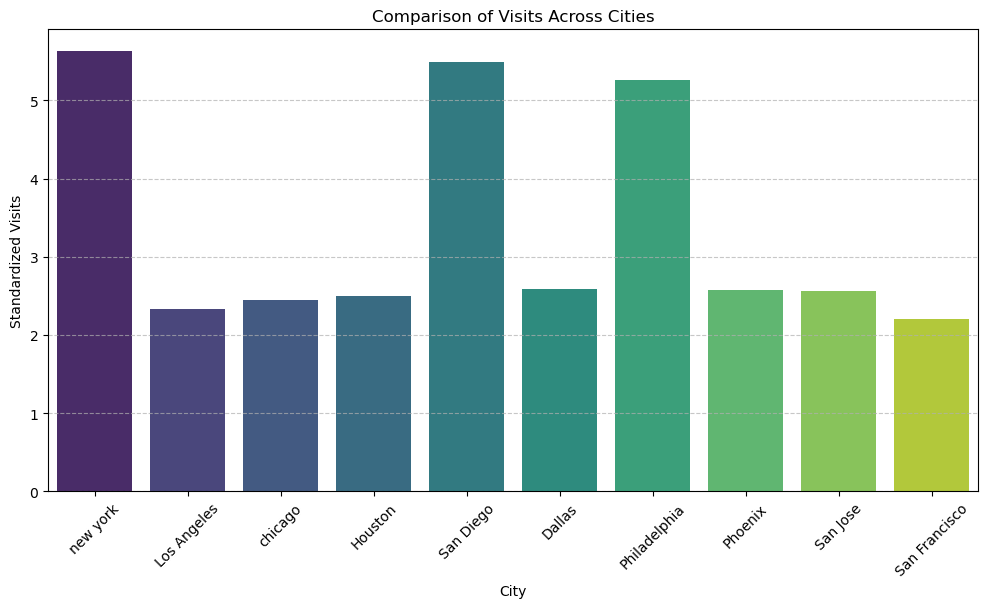

In [247]:
city_dfs = [NY_df, LA_df, IL_df, HT_df, SD_df, DA_df, PH_df, AZ_df, SJ_df, SF_df]  # Add all 10 city DataFrames here
city_concat = pd.concat(city_dfs, axis=0)

plt.figure(figsize=(12,6))
sns.barplot(x='state', y='log_visits', data=city_concat, errorbar=None, palette='viridis',hue='state')

plt.xlabel("City")
plt.ylabel("Standardized Visits")
plt.title("Comparison of Visits Across Cities")
plt.xticks(rotation=45)  # Rotate for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [248]:
city_stat = city_concat.groupby('state')['visits_by_cbg'].agg(['mean', 'median', 'std']).reset_index()

In [249]:
city_stat

,state,mean,median,std
0,Dallas,20.098101,10.0,27.597904
1,Houston,18.938224,10.0,32.168320
2,Los Angeles,14.615702,6.0,26.519057
3,Philadelphia,396.259096,222.0,509.715910
4,Phoenix,20.301613,9.0,29.696434
5,San Diego,470.699081,387.0,478.537054
6,San Francisco,10.454545,6.0,13.444900
7,San Jose,18.086792,11.0,35.630004
8,chicago,16.632750,10.0,35.092336
9,new york,747.043164,277.0,1837.218658


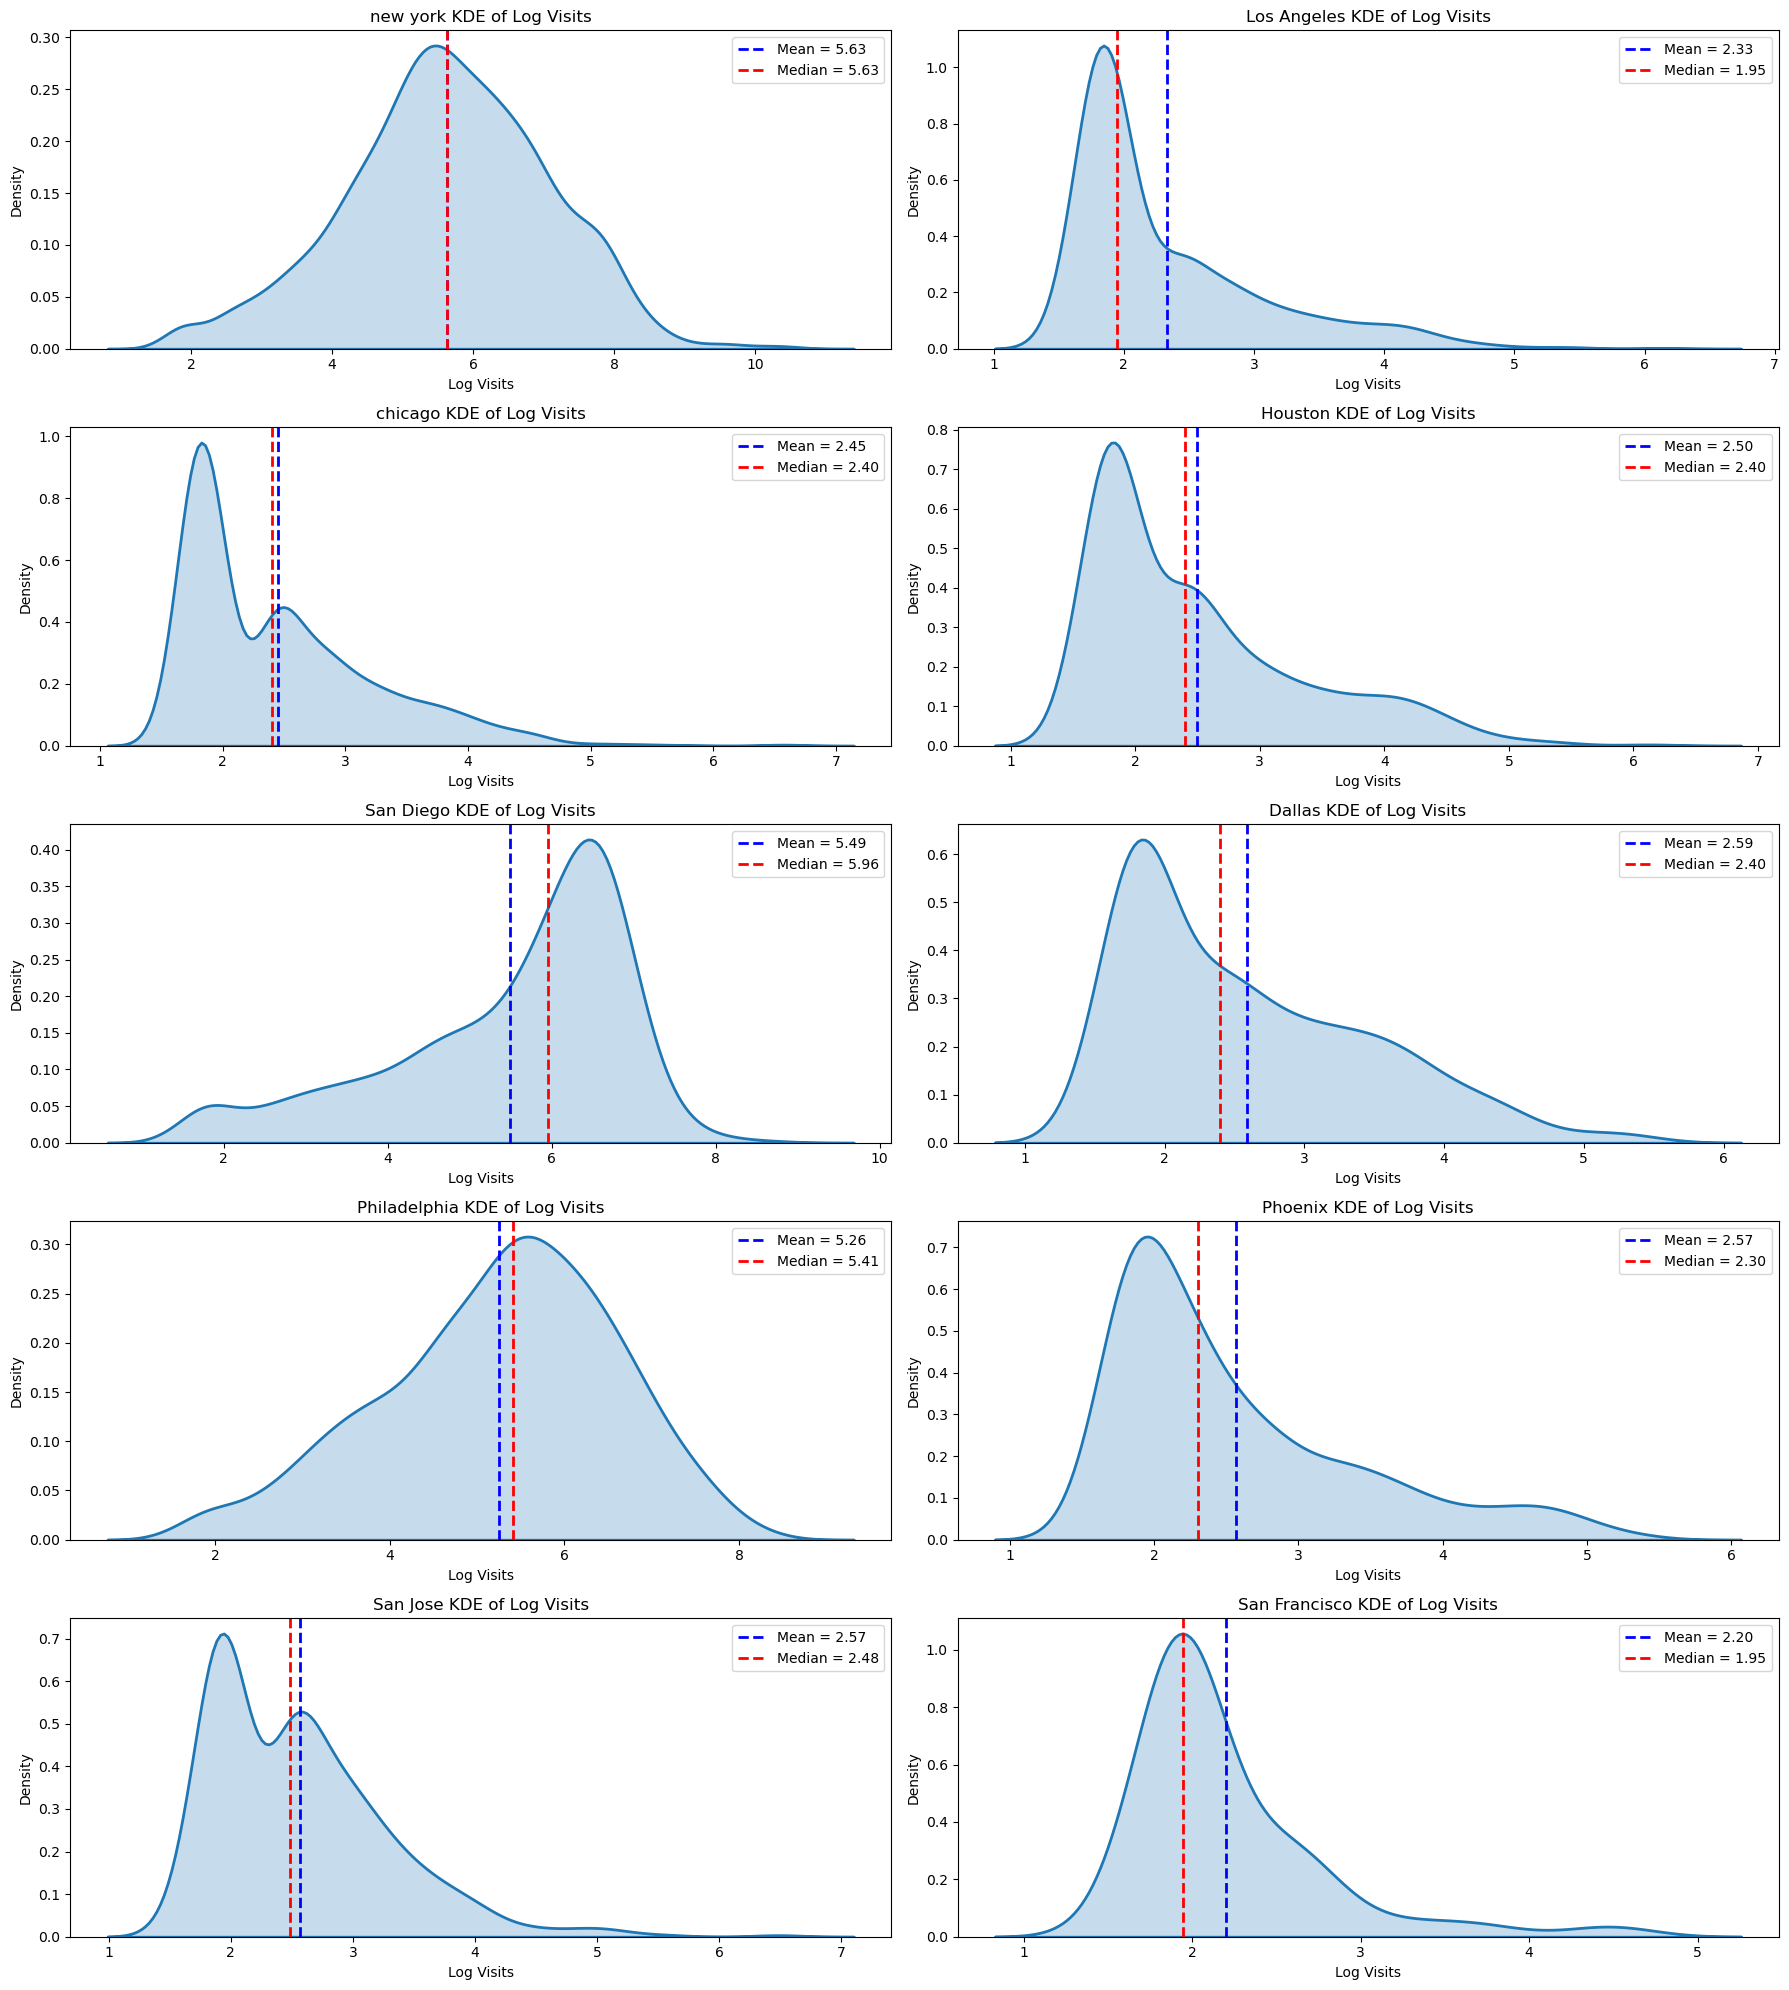

In [250]:
# Re-import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# List of city DataFrames (ensure these are loaded correctly)
city_dfs = [NY_df, LA_df, IL_df, HT_df, SD_df, DA_df, PH_df, AZ_df, SJ_df, SF_df]

# Concatenate all cities into one DataFrame
city_concat = pd.concat(city_dfs, axis=0)

# Create KDE plots for log_visits by city
plt.figure(figsize=(18, 20))

# Get unique city names
cities = city_concat['state'].unique()

# Create subplots for each city
for i, city in enumerate(cities, 1):
    plt.subplot(5, 2, i)  # 5 rows, 2 columns
    sns.kdeplot(city_concat[city_concat['state'] == city]['log_visits'], fill=True, linewidth=2)
    
    # Compute mean and median
    mean_value = city_concat[city_concat['state'] == city]['log_visits'].mean()
    median_value = city_concat[city_concat['state'] == city]['log_visits'].median()

    # Draw vertical lines
    plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=2, label=f"Mean = {mean_value:.2f}")
    plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2, label=f"Median = {median_value:.2f}")
    
    # Set title and labels
    plt.title(f"{city} KDE of Log Visits")
    plt.xlabel("Log Visits")
    plt.ylabel("Density")
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [251]:
import ace_tools_open as tools

In [252]:
NY_df1 = NY_df.copy()
LA_df1 = LA_df.copy()
IL_df1 = IL_df.copy()
PH_df1 = PH_df.copy()
HT_df1 = HT_df.copy()
SD_df1 = SD_df.copy()
AZ_df1 = AZ_df.copy()
DA_df1 = DA_df.copy()
SJ_df1 = SJ_df.copy()
SF_df1 = SF_df.copy()

## Summary Statistics of visits based on Median Income: Split income into quartiles (4 groups) 

# Question 3: Based on the observed patterns, is there sufficient evidence to suggest that future visitation patterns will change, potentially leading to improved park equity, as indicated by statistical and machine learning predictive models?

<p>To answer this question: Train ML models</p>

<p>Introduce H20 AutoML </p>

<p>AutoML is a function in H2O that automates the process of building a large number of models, with the goal of finding the "best" model without any prior knowledge or effort by the Data Scientist.

H2O AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. H2O offers a number of model explainability methods that apply to AutoML objects (groups of models), as well as individual models (e.g. leader model). Explanations can be generated automatically with a single function call, providing a simple interface to exploring and explaining the AutoML models.

The current version of AutoML trains and cross-validates the following algorithms: three pre-specified XGBoost GBM (Gradient Boosting Machine) models, a fixed grid of GLMs, a default Random Forest (DRF), five pre-specified H2O GBMs, a near-default Deep Neural Net, an Extremely Randomized Forest (XRT), a random grid of XGBoost GBMs, a random grid of H2O GBMs, and a random grid of Deep Neural Nets. In some cases, there will not be enough time to complete all the algorithms, so some may be missing from the leaderboard. In other cases, the grids will stop early, and if there’s time left, the top two random grids will be restarted to train more models. AutoML trains multiple Stacked Ensemble models throughout the process.

AutoML trains several Stacked Ensemble models during the run (unless ensembles are turned off using exclude_algos). We have subdivided the model training in AutoML into “model groups” with different priority levels. After each group is completed, and at the very end of the AutoML process, we train (at most) two additional Stacked Ensembles with the existing models. There are currently two types of Stacked Ensembles: one which includes all the base models (“All Models”), and one comprised only of the best model from each algorithm family (“Best of Family”). The Best of Family ensembles are more optimized for production use since it only contains six (or fewer) base models. It should be relatively fast to use in production (to generate predictions on new data) without much degradation in model performance when compared to the final “All Models” ensemble, for example. This may be useful if you want the model performance boost from ensembling without the added time or complexity of a large ensemble. You can also inspect some of the earlier “All Models” Stacked Ensembles that have fewer models as an alternative to the Best of Family ensembles. The metalearner used in all ensembles is a variant of the default Stacked Ensemble metalearner: a non-negative GLM with regularization (Lasso or Elastic net, chosen by CV) to encourage more sparse ensembles. The metalearner also uses a logit transform (on the base learner CV preds) for classification tasks before training.</p>

In [253]:
ddf_copy.columns

Index(['visitor_home_cbg', 'state', 'visits_by_cbg', 'median_dwell',
       'distance_from_home', 'median_income', 'pct_male', 'pct_female',
       'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_young',
       'pct_adult', 'pct_elderly', 'pct_low_edu', 'pct_high_edu',
       'pct_short_comute', 'pct_long_comute', 'pct_unemp', 'pct_emp',
       'pct_car', 'pct_public_trans', 'pct_0car', 'power_visits', 'log_visits',
       'log_distance', 'log_dwell', 'power_dwell', 'log_income',
       'dominant_race'],
      dtype='object')

In [254]:
LA_df1 = LA_df.copy()
IL_df1 = IL_df.copy()
PH_df1 = PH_df.copy()
HT_df1 = HT_df.copy()
SD_df1 = SD_df.copy()
AZ_df1 = AZ_df.copy()
DA_df1 = DA_df.copy()
SJ_df1 = SJ_df.copy()
SF_df1 = SF_df.copy()